# 📌 NOTEBOOK 2: MODELAGEM E ANÁLISE DE DADOS COM MODELOS DE NLP/LLM
**Inferência de Gênero e Análise de Sentimento em Decisões Judiciais**

## 🔧 1. CONFIGURAÇÃO DO AMBIENTE

### 1.1 Instalação de Dependência

In [ ]:
!pip install transformers torch pandas scikit-learn scipy seaborn matplotlib

### 1.2 Importação de Bibliotecas Principais

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from itertools import combinations

## 📥 2. CARREGAMENTO DOS DADOS

### 2.1 Carregar Dataset com Textos Completos
**Descrição**: Carregue o arquivo `decisoes_extraidas.csv` gerado após scrapping de PDF's e extração do texto de decisão, feitos no NOTEBOOK 1.

**Localização**: `..\data\notebook1\decisoes_extraidas.csv`

**Obs**: Carregamento pode demorar um pouco

In [ ]:
df = pd.read_csv("decisoes_extraidas.csv", sep=';')

print(f"Shape do dataset: {df.shape}")
df.head()

Shape do dataset: (805, 3)


,arquivo,numero_processo,decisao_completa
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ..."
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE..."
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE..."
3,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE..."
4,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria..."


## 🧠 3. EXTRAÇÃO DE ENTIDADES E INFERÊNCIA DE GÊNERO

### 3.1 Carregamento do Modelo NER (LeNER-BR)
**Descrição**: Carregamento do modelo LeNER-BR, um BERT fine-tuned para reconhecimento de entidades nomeadas em textos jurídicos brasileiros (identifica nomes de pessoas, organizações, locais)

**Hugging Face 🤗**: https://huggingface.co/pierreguillou/ner-bert-base-cased-pt-lenerbr

In [ ]:
from transformers import pipeline

# Modelo NER especializado em textos jurídicos brasileiros
ner_pipeline = pipeline(
    "ner",
    model="pierreguillou/ner-bert-base-cased-pt-lenerbr",
    aggregation_strategy="simple"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


### 3.2 Função de Detecção de Título (Juiz/Juíza)
**Descrição**: Função que busca por padrões de "Juiz" ou "Juíza" nos últimos 2000 caracteres do texto (onde geralmente está a assinatura). Usa regex com normalização para capturar variações ortográficas.

In [ ]:
def detectar_titulo_juiz(texto):
    """
    Procura no texto ocorrências de 'Juiz' ou 'Juíza' e retorna:
      - 'Juiz'    se a última ocorrência for masculina
      - 'Juíza'   se a última ocorrência for feminina
      - 'N/A'     se não encontrar nada confiável
    """
    if not texto:
        return "N/A"

    # Olhando no fim do texto onde geralmente está a assinatura
    trecho_fim = texto[-2000:]

    # Padrão regex para capturar variações de Juiz/Juíza
    padrao = r"Ju[ií]z(a)?"

    # Busca pelo padrão ignorando capitalização
    judge_search = re.search(padrao, trecho_fim, flags=re.IGNORECASE)

    # Caso não encontrado -> N/A
    if not judge_search:
        return "N/A"

    # Recupera o termo encontrado
    judge = judge_search.group(0)

    # Decisão: se termina com 'a' → Juíza, senão → Juiz
    if "a" in judge.lower():
        return "Juíza"
    else:
        return "Juiz"

### 3.3 Função de Inferência de Gênero do Juiz
**Descrição**: Converte o título detectado em categoria de gênero.

In [ ]:
def inferir_genero_juiz_por_titulo(texto):
    """
    Usa o título para inferir o gênero do juiz(a).
    """
    titulo = detectar_titulo_juiz(texto)
    if titulo == "Juiz":
        return "Masculino"
    elif titulo == "Juíza":
        return "Feminino"
    else:
        return "N/A"

### 3.4 Aplicação das Funções ao Dataset

In [ ]:
df["titulo_juiz"] = df["decisao_completa"].apply(detectar_titulo_juiz)
df["genero_juiz"] = df["decisao_completa"].apply(inferir_genero_juiz_por_titulo)

df[["numero_processo", "titulo_juiz", "genero_juiz"]].sample(10, random_state=42)

,numero_processo,titulo_juiz,genero_juiz
192,0200226-69.2022.8.06.0143,Juiz,Masculino
718,0272599-05.2023.8.06.0001,Juiz,Masculino
168,0200082-88.2023.8.06.0037,Juíza,Feminino
522,0242520-09.2024.8.06.0001,Juiz,Masculino
536,0244698-62.2023.8.06.0001,Juiz,Masculino
791,0291464-13.2022.8.06.0001,Juiz,Masculino
765,0281122-06.2023.8.06.0001,Juíza,Feminino
328,0204029-56.2022.8.06.0112,Juiz,Masculino
218,0200436-05.2022.8.06.0052,Juíza,Feminino
788,0288630-66.2024.8.06.0001,Juiz,Masculino


### 3.5 Função de Extração de Nomes via NER
**Descrição**: Função para extração de nomes de pessoas usando NER, com múltiplos filtros:

* Exige pelo menos 2 palavras (nome + sobrenome)
* Remove termos institucionais/genéricos
* Exige mínimo de 3 caracteres

**Limitação**: Alguns documentos não têm nomes identificáveis nos primeiros 1000 caracteres (cabeçalhos, citações longas, ruído), resultando em "Não identificado".

In [ ]:
def extrair_pessoas_via_ner(texto):
    """
    Roda NER no texto e retorna lista de entidades do tipo PESSOA,
    filtrando tokens quebrados, exigindo pelo menos 2 palavras
    e ignorando termos institucionais/genéricos.
    """
    if not isinstance(texto, str) or texto.strip() == "":
        return []

    entities = ner_pipeline(texto)
    pessoas = []

    # Lista de termos que não queremos considerar como "Parte" (Pessoa Física)
    termos_proibidos = [
        "justiça pública", "justica publica",
        "ministério público", "ministerio publico",
        "município", "municipio",
        "estado do", "união", "uniao",
        "fazenda pública", "fazenda publica",
        "defensoria", "procuradoria",
        "banco", "seguradora", "imobiliária"
    ]

    for ent in entities:
        if ent.get("entity_group") != "PESSOA":
            continue

        nome = ent.get("word", "").strip()

        # Ignorar subwords esquisitos tipo '##no'
        if "##" in nome:
            continue

        # Remover caracteres estranhos
        nome_limpo = re.sub(r"[^A-Za-zÁÉÍÓÚÂÊÔÃÕÇáéíóúâêôãõç\s]", "", nome).strip()

        # Pelo menos 2 "palavras" (nome + sobrenome etc.)
        if len(nome_limpo.split()) < 2:
            continue

        # Pelo menos 1 letra "de verdade"
        if not re.search(r"[A-Za-zÁÉÍÓÚÂÊÔÃÕÇáéíóúâêôãõç]", nome_limpo):
            continue

        # Filtro de termos proibidos (institucionais)
        nome_lower = nome_limpo.lower()
        if any(term in nome_lower for term in termos_proibidos):
            continue

        pessoas.append({
            "nome": nome_limpo,
            "start": ent.get("start", None),
            "end": ent.get("end", None),
        })

    return pessoas

### 3.6 Função de Extração de Nomes das Partes (Estratégia Híbrida)
**Descrição**: Função principal de extração com estratégia híbrida em 3 camadas:

* Regex formal: Busca por "Requerente:", "Autor:", "Paciente:"
* Regex narrativa: Busca por "ajuizada por", "intentada por", "promovida por"
* NER fallback: Usa modelo de NLP quando padrões textuais falham

**Importante**: Analisa apenas os primeiros 1000 caracteres para otimizar performance.

In [ ]:
import re

TERMOS_PROIBIDOS = [
    "ministério público", "ministerio publico",
    "justiça pública", "justica publica",
    "estado do", "município", "municipio",
    "união", "uniao", "fazenda pública", "fazenda publica",
    "defensoria", "procuradoria", "secretaria", "prefeitura",
    "tribunal", "comarca", "vara", "juizado",
]

FRASES_RUIDO = [
    "para emendar", "emendar a inicial", "para emenda", "emenda da inicial",
    "a suportar", "suportar dores", "dores de", "forte intensidade",
    "possui histórico", "historico de", "encontra se", "encontra-se",
    "dependente para", "atividades da vida",
]

STOPWORDS_NOME = {
    "para","a","o","as","os","de","da","do","das","dos","e","em","no","na","nos","nas",
    "por","com","sem","ao","aos","à","às"
}

def eh_proibido(nome: str) -> bool:
    if not isinstance(nome, str):
        return True
    n = nome.strip().lower()
    if any(t in n for t in TERMOS_PROIBIDOS):
        return True
    if any(fr in n for fr in FRASES_RUIDO):
        return True
    return False

def limpar_nome(nome: str) -> str:
    if not isinstance(nome, str):
        return ""
    nome = nome.strip()

    # remove prefixos comuns que vazam
    nome = re.sub(r"(?i)^(e\s+)?(o\s+)?(a\s+)?autor(a)?\b[:\s-]*", "", nome).strip()
    nome = re.sub(r"(?i)^(o\s+)?(a\s+)?requerente\b[:\s-]*", "", nome).strip()
    nome = re.sub(r"(?i)^(o\s+)?(a\s+)?paciente\b[:\s-]*", "", nome).strip()

    # corta em delimitadores
    nome = re.split(r"[\n;,]", nome)[0].strip()

    # remove lixo não-letra
    nome = re.sub(r"[^A-Za-zÁÉÍÓÚÂÊÔÃÕÇáéíóúâêôãõç\s]", " ", nome)
    nome = re.sub(r"\s+", " ", nome).strip()
    return nome

def parece_nome_pessoa(nome: str) -> bool:
    if not isinstance(nome, str):
        return False
    nome = nome.strip()
    parts = [p for p in nome.split() if p]
    if len(parts) < 2:
        return False

    conteudo = [p for p in parts if p.lower() not in STOPWORDS_NOME]
    if len(conteudo) < 2:
        return False

    good = sum((w[:1].isupper() or w.isupper()) for w in conteudo)
    if good < 2:
        return False

    if any((len(w) >= 12 and not (w[:1].isupper() or w.isupper())) for w in conteudo):
        return False

    return True

def extrair_pessoas_via_ner(texto: str, limite_chars: int = 1000):
    """
    Retorna lista de nomes candidatos (strings) vindos do NER,
    já limpos e filtrados.
    """
    if not isinstance(texto, str) or not texto.strip():
        return []

    trecho = texto[:limite_chars]

    # IMPORTANTE: truncation/max_length evita RuntimeError do BERT
    ents = ner_pipeline(trecho)

    candidatos = []
    for ent in ents:
        if ent.get("entity_group") != "PESSOA":
            continue

        nome = limpar_nome(ent.get("word", ""))
        if not nome:
            continue

        if eh_proibido(nome):
            continue

        if not parece_nome_pessoa(nome):
            continue

        candidatos.append(nome)

    # remove duplicados preservando ordem
    vistos = set()
    out = []
    for n in candidatos:
        k = n.lower()
        if k not in vistos:
            vistos.add(k)
            out.append(n)
    return out

def extrair_nome_parte(texto: str, limite_chars: int = 2500) -> str:
    if not isinstance(texto, str) or texto.strip() == "":
        return "Não identificado"

    trecho = texto[:limite_chars]

    # 1) Rótulos formais
    padroes_formais = [
        r"(?im)^\s*Paciente\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Requerente\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Autor(?:a)?\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Parte\s+autora\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Demandante\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Impetrante\s*:\s*([^\n]{3,150})",
        r"(?im)^\s*Exequente\s*:\s*([^\n]{3,150})",
    ]

    for p in padroes_formais:
        m = re.search(p, trecho)
        if m:
            cand = limpar_nome(m.group(1))
            if cand and (not eh_proibido(cand)) and parece_nome_pessoa(cand):
                return cand

    # 2) Narrativos
    padroes_narrativos = [
        r"(?i)\bajuizad[ao]\s+por\s+([^,.;\n]{3,150})",
        r"(?i)\bintentad[ao]\s+por\s+([^,.;\n]{3,150})",
        r"(?i)\bpropost[ao]\s+por\s+([^,.;\n]{3,150})",
        r"(?i)\bpromovid[ao]\s+por\s+([^,.;\n]{3,150})",
    ]

    for p in padroes_narrativos:
        m = re.search(p, trecho)
        if m:
            cand = limpar_nome(m.group(1))
            if cand and (not eh_proibido(cand)) and parece_nome_pessoa(cand):
                return cand

    # 3) Fallback NER
    candidatos = extrair_pessoas_via_ner(trecho, limite_chars=1000)
    if candidatos:
        # escolha robusta: o nome mais longo costuma ser o mais completo
        return max(candidatos, key=lambda s: len(s))

    return "Não identificado"

### 3.7 Aplicando no dataframe

In [ ]:
df["nome_parte"] = df["decisao_completa"].apply(extrair_nome_parte)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


### 3.8 Porcentagem de nomes das partes não identificadas

In [ ]:
nao_identificados = (df['nome_parte'] == "Não identificado").mean() * 100
n_nao_identificados = df['nome_parte'].eq("Não identificado").sum()

print(f"Porcentagem de nomes das partes não identificadas: {nao_identificados:.2f}%")
print(f"Quantidade: {n_nao_identificados}")

# Amostra
display(df[["numero_processo", "nome_parte"]].sample(5, random_state=42))

Porcentagem de nomes das partes não identificadas: 0.62%
Quantidade: 5


,numero_processo,nome_parte
192,0200226-69.2022.8.06.0143,MARIA IONEIDE DE ARAÚJO ANDRADE
718,0272599-05.2023.8.06.0001,Floriano Benevides Magalhaes
168,0200082-88.2023.8.06.0037,PEDRO LUCAS ALVES DOS SANTOS
522,0242520-09.2024.8.06.0001,Floriano Benevides Magalhaes
536,0244698-62.2023.8.06.0001,Jose Humberto Cortez Varela


### 3.9 Removendo registros não identificados do dataset


In [ ]:
# Removendo registros onde o nome da parte é 'Não identificado'
df = df[df['nome_parte'] != "Não identificado"]

print(f"Registros restantes: {df.shape[0]}")
df.sample(5)

Registros restantes: 800


,arquivo,numero_processo,decisao_completa,titulo_juiz,genero_juiz,nome_parte
790,02910363120228060001.pdf,0291036-31.2022.8.06.0001,26ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Juiz,Masculino,LUIS BARROS MONTENEGRO NETO em face da HAPVIDA...
791,02914641320228060001.pdf,0291464-13.2022.8.06.0001,25ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Juiz,Masculino,Francisco Ferreira dos Santos
792,02915343020228060001.pdf,0291534-30.2022.8.06.0001,37ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Juiz,Masculino,Floriano Benevides Magalhaes
793,02921466520228060001.pdf,0292146-65.2022.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Juíza,Feminino,Maria Clara Guimarães de Figueiredo
794,02940468320228060001.pdf,0294046-83.2022.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Juíza,Feminino,Francisco Claudio de Andrade Lima Filho
795,02964882220228060001.pdf,0296488-22.2022.8.06.0001,10ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Juíza,Feminino,PEDRO EVANDRO BANDEIRA LESSA e outro em face d...
796,02965661620228060001.pdf,0296566-16.2022.8.06.0001,14ª Vara de Família (SEJUD 1º Grau) Rua Desemb...,Juiz,Masculino,Adriano José Nascimento de Oliveira em face de...
797,02969914320228060001.pdf,0296991-43.2022.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Juíza,Feminino,Floriano Benevides Magalhaes
798,08000022220228060163.pdf,0800002-22.2022.8.06.0163,2ª Vara da Comarca de São Benedito Av. Tabajar...,Juíza,Feminino,Maria Lívia Gonçalves do Nascimento
799,08000065120238060122.pdf,0800006-51.2023.8.06.0122,"Rua Capitão Miguel Dantas, 1000, Centro - CEP ...",Juiz,Masculino,DA FELIPE LEITE


### 3.10 Carregamento do Modelo Zero-Shot Classification (Bart-Large-MNLI)
**Descrição**: Carregamento do modelo facebook/bart-large-mnli, um modelo BART de grande porte treinado no dataset MultiNLI (MNLI), utilizado para classificação de textos em zero-shot para tarefas de classificação, análise de conteúdo e rotulagem. Em nosso caso, a análise do gênero baseado no nome da parte

**Hugging Face** 🤗: https://huggingface.co/facebook/bart-large-mnli



In [ ]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Device set to use cuda:0


### 3.11 Função de Inferência de Gênero da Parte (via Nome com Zero-Shot)

In [ ]:
def identificar_genero(nome):
    """
    Usa zero-shot classification para inferir o gênero a partir do PRIMEIRO nome.
    Retorna 'Masculino' ou 'Feminino'.
    """
    if not isinstance(nome, str) or nome.strip() == "" or nome == "Não identificado":
        return "N/A"

    # Pegar apenas o primeiro nome para evitar ruído dos sobrenomes
    primeiro_nome = nome.strip().split()[0]

    labels = ["Masculino", "Feminino"]

    resultado = classifier(
        primeiro_nome,
        candidate_labels=labels,
        hypothesis_template="Este nome pertence ao gênero {}."
    )

    # O pipeline retorna ordenado por score decrescente, então o índice 0 é o vencedor
    return resultado["labels"][0]

### 3.12 Aplicando a função de indentificação de gênero para a parte

In [ ]:
df["genero_parte"] = df["nome_parte"].apply(identificar_genero)

df[["numero_processo", "nome_parte", "genero_parte", "titulo_juiz", "genero_juiz"]].head()

,numero_processo,nome_parte,genero_parte,titulo_juiz,genero_juiz
0,0000303-16.2017.8.06.0215,José Arteiro de Araújo,Masculino,Juiz,Masculino
1,0000498-37.2018.8.06.0127,Maria Jose Silva de Araujo,Feminino,Juíza,Feminino
2,0000618-80.2018.8.06.0127,Luiz Mateus Santos da Costa,Masculino,Juíza,Feminino
3,0000965-79.2019.8.06.0127,Francisco Roberto Rodrigues da Silva,Masculino,Juíza,Feminino
4,0001314-44.2018.8.06.0151,Y FERREIRA DE OLIVEIRA,Masculino,Juiz,Masculino


### 3.13 Verificando existência de valores nulos

In [ ]:
# Contar quantidade de valores nulos (NaN) nas colunas de gênero
nulos_genero = df[['genero_juiz', 'genero_parte']].isna().sum()
print(nulos_genero)

display(df.head(4))

genero_juiz     0
genero_parte    0
dtype: int64


,arquivo,numero_processo,decisao_completa,titulo_juiz,genero_juiz,nome_parte,genero_parte
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Juiz,Masculino,José Arteiro de Araújo,Masculino
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Juíza,Feminino,Maria Jose Silva de Araujo,Feminino
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Juíza,Feminino,Luiz Mateus Santos da Costa,Masculino
3,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Juíza,Feminino,Francisco Roberto Rodrigues da Silva,Masculino


### 3.14 Removendo colunas parciais de nome

In [ ]:
df = df.drop(columns=["nome_parte", "titulo_juiz"])

In [ ]:
display(df)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino
3,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino
4,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria...",Masculino,Masculino
...,...,...,...,...,...
800,08000076520238060177.pdf,0800007-65.2023.8.06.0177,"Rua Carlos Antônio Sales, nº 401, Centro - CEP...",Masculino,Masculino
801,08000088520248060057.pdf,0800008-85.2024.8.06.0057,"Rua Coronel Francisco Linhares, S/N, Centro - ...",Masculino,Masculino
802,08000093520238060177.pdf,0800009-35.2023.8.06.0177,"Rua Carlos Antônio Sales, nº 401, Centro - CEP...",Masculino,Masculino
803,08000118820228060096.pdf,0800011-88.2022.8.06.0096,"CEL. GUILHERMINO, S/N, PRAÇA DE CRISTO - CEP 6...",Feminino,Masculino


### 3.15 Salvando resultados parciais

In [ ]:
df.to_csv("decisoes_com_genero.csv", index=False, sep=";")

## 🎯 4. CLASSIFICAR SENTENÇAS EM PROCEDENTES E IMPROCEDENTES


### 4.1 Função de classificação
**Descrição**: Aqui vamos usar regras de palavras-chave. Ajuste os termos conforme você observar nos textos do seu tribunal.

**Regras**:

1. Se contém a palavra "IMPROCEDENTE" ou sinônimo: `Improcedente`

1. Se contém "PROCEDENTE" ou sinônimo: `Procedente`

1. Caso contrário: `Não identificado`

In [ ]:
def classificar_sentenca(texto):
    t = texto.upper()

    if "JULGO IMPROCEDENTE" in t or "JULGAM IMPROCEDENTE" in t:
        return "Improcedente"

    if "JULGO PROCEDENTE" in t or "JULGAM PROCEDENTE" in t:
        return "Procedente"

    if "IMPROCEDENTE" in t or "INDEFERIDO" or "INDEFIRO" in t:
        return "Improcedente"
    if "PROCEDENTE" in t or "DEFERIDO" in t or "DEFIRO" in t:
        return "Procedente"

    return "Não identificado"


### 4.2 Aplicando classificação de sentença no dataframe

In [ ]:
df["resultado_sentenca"] = df["decisao_completa"].apply(classificar_sentenca)

df["resultado_sentenca"].value_counts(dropna=False)

,count
resultado_sentenca,
Procedente,566
Improcedente,234


### 4.3 Verificando resultados antes de salvar

In [ ]:
print(df.columns)
print(df.shape)
df.head(5)

Index(['arquivo', 'numero_processo', 'decisao_completa', 'genero_juiz',
       'genero_parte', 'resultado_sentenca'],
      dtype='object')
(800, 6)


,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente
3,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente
4,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria...",Masculino,Masculino,Improcedente


### 4.4 Salvando resultados

In [ ]:
# Salvando em csv

df.to_csv("decisoes_classificadas_com_genero.csv", index=False, sep=";")

## 📚 5. PRÉ-PROCESSAMENTO DO TEXTO

- https://garyeckstein.com/clean-text-for-data-analysis/

### 5.1 Removendo espaços em branco


In [ ]:
# Remove whitespaces
def remove_whitespaces(decisao_completa):
    return  " ".join(decisao_completa.split())

df['decisao_completa']=df['decisao_completa'].apply(remove_whitespaces)
df.head(5)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente
3,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente
4,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria...",Masculino,Masculino,Improcedente


### 5.2 Lematização
**Descrição**: Mapeia palavras para suas formas base de dicionário, conhecida como **lema**.

Ex: lematização de "sou" retorna "ser"

Por que é importante: reduzir dimensionalidade dos dados sem perder contexto semântico, melhorando classificação em NLP

A lematização foi realizada antes da remoção de stopwords e pontuação, a fim de preservar o contexto morfossintático das sentenças, garantindo maior precisão linguística na normalização dos termos jurídicos.


### 5.3 Instalando e importando bibliotecas

In [ ]:
!pip -q install spacy
!python -m spacy download pt_core_news_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 167.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

nlp = spacy.load("pt_core_news_sm", disable=["ner", "parser"])
# Mantém o tagger/lemmatizer e desliga o resto para ficar mais rápido.

### 5.4 Função de lemetização

In [ ]:
def lemmatize_spacy_from_token_lists(lista_de_listas_tokens, batch_size=64, n_process=1):
    """
    Entrada: lista_de_listas_tokens -> [ ["token1","token2",...], ["token1",...], ... ]
    Saída: lista de listas de lemas (mesmo shape)
    """
    # transforma cada doc em string (spacy precisa de texto)
    textos = (" ".join(tokens) for tokens in lista_de_listas_tokens)

    saida = []
    for doc in nlp.pipe(textos, batch_size=batch_size, n_process=n_process):
        saida.append([t.lemma_ for t in doc])
    return saida

### 5.5 Aplicando no dataset

In [ ]:
df["lemmas"] = [
    [t.lemma_ for t in doc]
    for doc in nlp.pipe(df["decisao_completa"].tolist(), batch_size=100, n_process=-1)
]
df.head(3)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,lemmas
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente,"[Av, Paulo, Bastos, ,, 802, ,, Centro, -, CEP,..."
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,"[PRAÇA, LUIZ, ALVES, de, MESQUITA, ,, S, /, N,..."
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,"[PRAÇA, LUIZ, ALVES, de, MESQUITA, ,, S, /, N,..."


### 5.6 Baixando nltk (Natural Language Toolkit) para realizar o pré-processamento e preparação do texto

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Load NLTK stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('portuguese'))
en_stopwords = stopwords.words('portuguese')

# Criando um dataframe para salvar em csv as stopwords
df_stopwords = pd.DataFrame(en_stopwords, columns=['stopwords'])
df_stopwords.to_csv('custom_stopwords.csv', index=False)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### 5.7 Carregando stopwords

In [ ]:
# Load custom stopwords
with open(r'custom_stopwords.csv', 'r') as f:
    custom_stopwords = f.read().strip().split(",")

custom_stopwords

['stopwords\na\nà\nao\naos\naquela\naquelas\naquele\naqueles\naquilo\nas\nàs\naté\ncom\ncomo\nda\ndas\nde\ndela\ndelas\ndele\ndeles\ndepois\ndo\ndos\ne\né\nela\nelas\nele\neles\nem\nentre\nera\neram\néramos\nessa\nessas\nesse\nesses\nesta\nestá\nestamos\nestão\nestar\nestas\nestava\nestavam\nestávamos\neste\nesteja\nestejam\nestejamos\nestes\nesteve\nestive\nestivemos\nestiver\nestivera\nestiveram\nestivéramos\nestiverem\nestivermos\nestivesse\nestivessem\nestivéssemos\nestou\neu\nfoi\nfomos\nfor\nfora\nforam\nfôramos\nforem\nformos\nfosse\nfossem\nfôssemos\nfui\nhá\nhaja\nhajam\nhajamos\nhão\nhavemos\nhaver\nhei\nhouve\nhouvemos\nhouver\nhouvera\nhouverá\nhouveram\nhouvéramos\nhouverão\nhouverei\nhouverem\nhouveremos\nhouveria\nhouveriam\nhouveríamos\nhouvermos\nhouvesse\nhouvessem\nhouvéssemos\nisso\nisto\njá\nlhe\nlhes\nmais\nmas\nme\nmesmo\nmeu\nmeus\nminha\nminhas\nmuito\nna\nnão\nnas\nnem\nno\nnos\nnós\nnossa\nnossas\nnosso\nnossos\nnum\nnuma\no\nos\nou\npara\npela\npelas\npelo\n

### 5.8 Removendo stopwords

In [ ]:
# Remove the stopwords

def remove_stopwords(lemmas):
    result = []
    for token in lemmas:
        if token not in en_stopwords and token not in custom_stopwords:
            result.append(token)

    return result

df['lemmas'] = df['lemmas'].apply(remove_stopwords)
df.head(3)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,lemmas
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente,"[Av, Paulo, Bastos, ,, 802, ,, Centro, -, CEP,..."
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,"[PRAÇA, LUIZ, ALVES, MESQUITA, ,, S, /, N, ,, ..."
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,"[PRAÇA, LUIZ, ALVES, MESQUITA, ,, S, /, N, ,, ..."


### 5.9. Removendo pontuação

In [ ]:
# Remove punctuation
from nltk.tokenize import RegexpTokenizer

def remove_punct(lemmas):

    tokenizer = RegexpTokenizer(r"\w+")
    lst=tokenizer.tokenize(' '.join(lemmas))
    return lst

df['lemmas'] = df['lemmas'].apply(remove_punct)
df.head(3)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,lemmas
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente,"[Av, Paulo, Bastos, 802, Centro, CEP, 62620, 0..."
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,"[PRAÇA, LUIZ, ALVES, MESQUITA, S, N, CENTRO, C..."
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,"[PRAÇA, LUIZ, ALVES, MESQUITA, S, N, CENTRO, C..."


### 5.10 Transformando em string novamente

In [ ]:
# Convert list to string
df['decisao_processada'] = [' '.join(map(str, l)) for l in df['lemmas']]
df.head(3)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,lemmas,decisao_processada
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente,"[Av, Paulo, Bastos, 802, Centro, CEP, 62620, 0...",Av Paulo Bastos 802 Centro CEP 62620 000 Fone ...
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,"[PRAÇA, LUIZ, ALVES, MESQUITA, S, N, CENTRO, C...",PRAÇA LUIZ ALVES MESQUITA S N CENTRO CEP 63780...
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,"[PRAÇA, LUIZ, ALVES, MESQUITA, S, N, CENTRO, C...",PRAÇA LUIZ ALVES MESQUITA S N CENTRO CEP 63780...


### 5.11 Remove palavras com 2 caracteres ou menos

In [ ]:
#Remove words 2 characters in length and less
df['decisao_processada'] = df.decisao_processada.str.replace(r'\b(\w{1,2})\b', '', regex=True)

df.head(3)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,lemmas,decisao_processada
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente,"[Av, Paulo, Bastos, 802, Centro, CEP, 62620, 0...",Paulo Bastos 802 Centro CEP 62620 000 Fone 3...
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,"[PRAÇA, LUIZ, ALVES, MESQUITA, S, N, CENTRO, C...",PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 0...
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,"[PRAÇA, LUIZ, ALVES, MESQUITA, S, N, CENTRO, C...",PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 0...


### 5.12 Remove espaços em branco e urls

In [ ]:
import re
# Remove whitespaces and urls
def remove_whitespaces(decisao_processada):
    return  " ".join(decisao_processada.split())

def remove_url(decisao_processada):
    return re.sub(r'http\S+|www.\S+', '', decisao_processada)


df['decisao_processada']=df['decisao_processada'].apply(remove_whitespaces).apply(remove_url)
df.head(3)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,lemmas,decisao_processada
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente,"[Av, Paulo, Bastos, 802, Centro, CEP, 62620, 0...",Paulo Bastos 802 Centro CEP 62620 000 Fone 363...
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,"[PRAÇA, LUIZ, ALVES, MESQUITA, S, N, CENTRO, C...",PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,"[PRAÇA, LUIZ, ALVES, MESQUITA, S, N, CENTRO, C...",PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...


### 5.13 Limpando coluna de lemmas

In [ ]:
# removendo coluna lemmas

df = df.drop(columns=['lemmas'])
df.head(3)

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,decisao_processada
0,00003031620178060215.pdf,0000303-16.2017.8.06.0215,"Av Paulo Bastos, 802, Centro - CEP 62620-000, ...",Masculino,Masculino,Procedente,Paulo Bastos 802 Centro CEP 62620 000 Fone 363...
1,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...
2,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...


### 5.14 Salvando resultados

In [ ]:
df.to_csv("decisoes_processadas_genero.csv", index=False, sep=";")

## 🤖 6. ANÁLISE DE SENTIMENTO COM LLM
**Observação**: Pule para o resultados gerados no item `6.8`, apenas veja os resultados gerados.

### 6.1 Carregando o csv com decisões pré-processadas e gêneros inferidos

In [ ]:
df = pd.read_csv("decisoes_processadas_generfdo.csv", sep=";")

### 6.2 Instalando OpenRouter
**Descrição**: O OpenRouter funciona como um hall de modelos, facilitando o uso de diferentes LLMs.

In [ ]:
%pip install llama-index-llms-openrouter
!pip install llama-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


INFO: pip is looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.2/328.2 kB 42.2 MB/s eta 0:00:00
  Attempting uninstall: deprecated
    Found existing installation: Deprecated 1.3.1
    Uninstalling Deprecated-1.3.1:


### 6.3 Importando bibliotecas

In [ ]:
from llama_index.llms.openrouter import OpenRouter
from llama_index.core.llms import ChatMessage

### 6.4 Configurando API Key do OpenRouter


In [ ]:
import os
from google.colab import userdata

os.environ['OPENROUTER_API_KEY'] = userdata.get("Open-Router_API-KEY")

### 6.5 Configuração dos modelos
**Descrição**: Foram avaliados múltiplos modelos disponíveis no OpenRouter, permitindo comparação de estabilidade e coerência:

* mistralai/mixtral-8x7b-instruct
* openai/gpt-oss-120b
* openai/gpt-4o-mini
* meta-llama/llama-3.3-70b-instruct
* deepseek/deepseek-v3.2
* x-ai/grok-4.1-fast

**Referência**: https://openrouter.ai/docs

In [ ]:
llm_mistral = OpenRouter(model="mistralai/mixtral-8x7b-instruct")
llm_gpt = OpenRouter(model="openai/gpt-oss-120b")
llm_gpt_mini = OpenRouter(model="openai/gpt-4o-mini")
llm_llama = OpenRouter(model="meta-llama/llama-3.3-70b-instruct")
llm_deepseek = OpenRouter(model="deepseek/deepseek-v3.2")
llm_grok = OpenRouter(model="x-ai/grok-4.1-fast")

### 6.6 Função de prompt
**Descrição**: O prompt foi cuidadosamente projetado para:

* Restringir o modelo ao texto pré-processado;
* Fornecer contexto estruturado mínimo (resultado da sentença, gênero do juiz e da parte);
* Evitar explicações, justificativas ou vieses externos.

A classificação é feita em **três categorias** exclusivas:

* **EMPÁTICA** – Linguagem humanizada e snsível ao contexto da parte;
* **TÉCNICA** – Linguagem neutra, objetiva e predominantemente jurídica;
* **RIGOROSA** – Linguagem dura, formal ou censória, com

In [ ]:
import re
import time
from llama_index.core.llms import ChatMessage

def montar_prompt(resultado_sentenca, genero_juiz, genero_parte, decisao_processada) -> str:
    return f"""
Você é um especialista em análise de linguagem jurídica e argumentação judicial.

Sua tarefa é classificar o **TOM DA DECISÃO JUDICIAL** com base **EXCLUSIVAMENTE**:
- no texto da decisão (pré-processado)
- no contexto estruturado fornecido

# DIRETRIZES
- NÃO avalie correção jurídica, justiça da decisão ou resultado do processo.
- NÃO use conhecimentos externos.
- NÃO explique sua resposta.

────────────────────────────────
# CONTEXTO ESTRUTURADO
────────────────────────────────
Resultado da sentença: {resultado_sentenca}
Gênero do(a) juiz(a): {genero_juiz}
Gênero da parte: {genero_parte}

────────────────────────────────
# TEXTO DA DECISÃO (pré-processado)
────────────────────────────────
\"\"\"{decisao_processada}\"\"\"

────────────────────────────────
# CRITÉRIOS DE CLASSIFICAÇÃO
────────────────────────────────

Classifique o TOM predominante do texto em **APENAS UMA** das categorias abaixo:

• **EMPATICA**
  - Linguagem humanizada ou acolhedora
  - Demonstra preocupação com dignidade, sofrimento, vulnerabilidade ou situação pessoal da parte
  - Uso de expressões que reconhecem contexto social, humano ou existencial
  - Mesmo quando técnica, apresenta sensibilidade explícita

• **TECNICA**
  - Linguagem neutra e impessoal
  - Fundamentação jurídica objetiva
  - Predomínio de dispositivos legais, precedentes, conceitos jurídicos
  - Ausência de juízo emocional positivo ou negativo

• **RIGOROSA**
  - Linguagem dura, fria ou excessivamente formal
  - Tom repreensivo, censório ou de pouca concessão
  - Ênfase em limites legais sem contextualização humana
  - Eventual censura moral, reprovação ou desconsideração da situação da parte

────────────────────────────────
# FORMATO OBRIGATÓRIO DE SAÍDA
────────────────────────────────

Retorne **EXATAMENTE UMA PALAVRA**, em letras maiúsculas, sem pontuação, sem explicações adicionais:

EMPATICA
TECNICA
RIGOROSA
"""

def extrair_sentimento(texto):
    t = texto.strip().upper()
    # pega a primeira ocorrência de uma classe válida
    m = re.search(r"\b(EMPATICA|TECNICA|RIGOROSA)\b", t)
    return m.group(1)

def classificar_tom(row, llm, max_retries=3) -> str:
    prompt = montar_prompt(
        row["resultado_sentenca"],
        row["genero_juiz"],
        row["genero_parte"],
        row["decisao_processada"],
    )

    msg = ChatMessage(role="user", content=prompt)

    for _ in range(max_retries):
        try:
            resp = llm.chat([msg])
            return extrair_sentimento(str(resp))

        except Exception:
            time.sleep(1)

    return "ERRO"


### 6.7 Aplicação no dataframe a análise de cada um dos modelos

In [ ]:
# @title Mistral
df["sentimento_llm_mistral"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_mistral), axis = 1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-4134012958.py", line 2, in <cell line: 0>
    df["sentimento_llm_mistral"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_mistral), axis = 1)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/frame.py", line 10374, in apply
    return op.apply().__finalize__(self, method="apply")
           ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/apply.py", line 916, in apply
    return self.apply_standard()
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/apply.py", line 1063, in apply_standard
    results, res_index = self.apply_series_generator()
                         ^^^

TypeError: object of type 'NoneType' has no len()

In [ ]:
# @title GPT
df["sentimento_llm-gpt"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_gpt), axis = 1)

In [ ]:
# @title GPT Mini
df["sentimento_llm-gpt-mini"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_gpt_mini), axis = 1)

In [ ]:
# @title Llama
df["sentimento_llm-llama"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_llama), axis = 1)

In [ ]:
# @title DeepSeek
df["sentimento_llm-deep-seek"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_llama), axis = 1)

In [ ]:
# @title Grok
df["sentimento_llm-grok"] = df.apply(lambda sentiment: classificar_tom(sentiment, llm_grok), axis = 1)

### 6.8 Geração dos resultados encontrados

In [ ]:
# @title Lendo o csv com as decisões já processadas
import pandas as pd
df = pd.read_csv("decisoes_classificadas_cs_llm.csv", sep=";")

In [ ]:
display(df['sentimento_llm_mistral'].value_counts())
display(df['sentimento_llm-gpt'].value_counts())
display(df['sentimento_llm-gpt-mini'].value_counts())
display(df['sentimento_llm-llama'].value_counts())
display(df['sentimento_llm-deep-seek'].value_counts())
display(df['sentimento_llm-grok'].value_counts())

display(df.head(4))

,count
sentimento_llm_mistral,
EMPATICA,663
TECNICA,89


,count
sentimento_llm-gpt,
TECNICA,722
EMPATICA,22
ERRO,7
RIGOROSA,1


,count
sentimento_llm-gpt-mini,
EMPATICA,382
TECNICA,224
RIGOROSA,146


,count
sentimento_llm-llama,
TECNICA,708
EMPATICA,44


,count
sentimento_llm-deep-seek,
TECNICA,711
EMPATICA,41


,count
sentimento_llm-grok,
EMPATICA,525
TECNICA,222
RIGOROSA,5


,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,decisao_processada,sentimento_llm_mistral,sentimento_llm-gpt,sentimento_llm-gpt-mini,sentimento_llm-llama,sentimento_llm-deep-seek,sentimento_llm-grok
0,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA
1,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,ERRO,EMPATICA,EMPATICA,EMPATICA,EMPATICA
2,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA
3,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria...",Masculino,Masculino,Improcedente,Vara Comarca Quixadá Jesus Maria José Jardim M...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA


### 6.9 Salvando resultados das decisoes classificadas

In [ ]:
# Salvando em csv:

df.to_csv("decisoes_classificadas_cs_llm.csv", index=False, sep=";")

### 6.10 Analisando custos por modelo
**Descrição** Análise de preço, tempo de uso para comparação entre modelos.

In [ ]:
import pandas as pd

df_open_router = pd.read_csv("open_router.csv")

In [ ]:
df_open_router.columns

Index(['generation_id', 'created_at', 'cost_total', 'cost_web_search',
       'cost_cache', 'cost_file_processing', 'byok_usage_inference',
       'tokens_prompt', 'tokens_completion', 'tokens_reasoning',
       'model_permaslug', 'provider_name', 'variant', 'cancelled', 'streamed',
       'user', 'finish_reason_raw', 'finish_reason_normalized',
       'generation_time_ms', 'time_to_first_token_ms', 'app_name',
       'api_key_name'],
      dtype='object')

In [ ]:
import pandas as pd

df_open_router = pd.read_csv("open_router.csv")

# tempo total por linha (ms)
df_open_router["tempo_ms"] = (
    df_open_router["generation_time_ms"].fillna(0)
    + df_open_router["time_to_first_token_ms"].fillna(0)
)

resumo_modelo = (
    df_open_router
    .groupby("model_permaslug", as_index=False)
    .agg(
        chamadas=("generation_id", "count"),
        preco_total=("cost_total", "sum"),
        tempo_total_ms=("tempo_ms", "sum"),
        tokens_prompt=("tokens_prompt", "sum"),
        tokens_completion=("tokens_completion", "sum"),
        tokens_reasoning=("tokens_reasoning", "sum"),
    )
)

PARAMETROS = {
    "mistralai/mixtral-8x7b-instruct": 32768,
    "meta-llama/llama-3.3-70b-instruct": 131072,
    "x-ai/grok-4.1-fast": 2000000,
    "openai/gpt-4o-mini": 128000,
    "openai/gpt-oss-120b": 131072,
}

# métricas derivadas
resumo_modelo["tempo_total_s"] = resumo_modelo["tempo_total_ms"] / 1000
resumo_modelo["preco_medio_por_chamada"] = resumo_modelo["preco_total"] / resumo_modelo["chamadas"]
resumo_modelo["tempo_medio_ms_por_chamada"] = resumo_modelo["tempo_total_ms"] / resumo_modelo["chamadas"]

resumo_modelo['parametros'] = resumo_modelo['model_permaslug'].map(PARAMETROS)

display(resumo_modelo.sort_values("preco_total", ascending=False))

,model_permaslug,chamadas,preco_total,tempo_total_ms,tokens_prompt,tokens_completion,tokens_reasoning,tempo_total_s,preco_medio_por_chamada,tempo_medio_ms_por_chamada,parametros
1,mistralai/mixtral-8x7b-instruct,778,2.570629,960200,4507889,5670,0,960.200,0.003304,1234.190231,32768
0,meta-llama/llama-3.3-70b-instruct,1504,1.743052,972154,7418807,6005,0,972.154,0.001159,646.378989,131072
4,x-ai/grok-4.1-fast,752,0.879856,13381442,3120306,562734,560473,13381.442,0.001170,17794.470745,2000000
2,openai/gpt-4o-mini,752,0.450083,548738,2993397,2402,0,548.738,0.000599,729.704787,128000
3,openai/gpt-oss-120b,811,0.238687,2365620,3243936,146497,151410,2365.620,0.000294,2916.917386,131072


### 6.11 Salvando

In [ ]:
cols = [
    "model_permaslug",
    "parametros",
    "chamadas",
    "preco_total",
    "tempo_total_s",
    "preco_medio_por_chamada",
    "tempo_medio_ms_por_chamada",
    "tokens_prompt",
    "tokens_completion",
    "tokens_reasoning",
]

resumo_modelo[cols].to_csv("open_router_estatisticas.csv", index=False)

### 6.12 Gráficos comparativos entre dados do Open Router

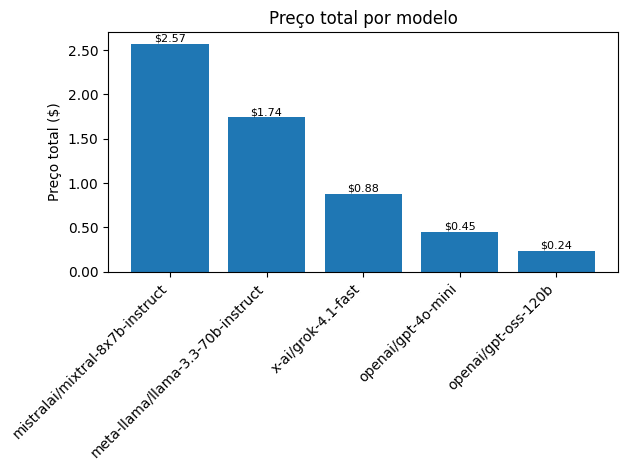

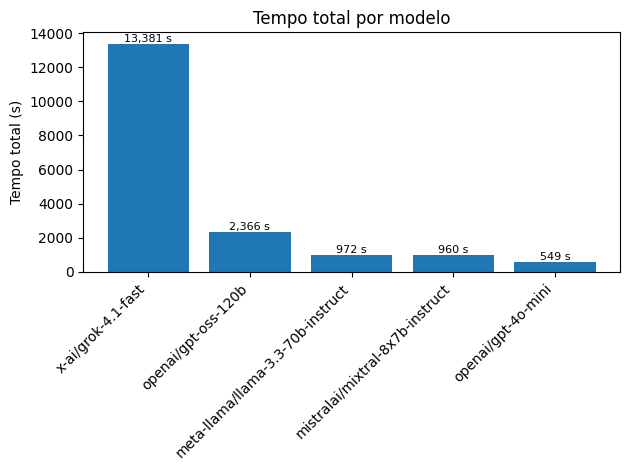

,model_permaslug,preco_total,tempo_total
0,mistralai/mixtral-8x7b-instruct,$2.57,960.20 s
1,meta-llama/llama-3.3-70b-instruct,$1.74,972.15 s
2,x-ai/grok-4.1-fast,$0.88,"13,381.44 s"
3,openai/gpt-4o-mini,$0.45,548.74 s
4,openai/gpt-oss-120b,$0.24,"2,365.62 s"


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 1) Ler o CSV
df = pd.read_csv("open_router_estatisticas.csv")

# 2) Garantir que as colunas numéricas estejam como número
colunas_numericas = ["preco_total", "tempo_total_s", "tempo_total_ms"]
for col in colunas_numericas:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 3) Criar a coluna tempo_total (prioriza segundos; se não existir, usa ms)
if "tempo_total_s" in df.columns and df["tempo_total_s"].notna().any():
    df["tempo_total"] = df["tempo_total_s"]
    unidade_tempo = "s"
elif "tempo_total_ms" in df.columns and df["tempo_total_ms"].notna().any():
    df["tempo_total"] = df["tempo_total_ms"]
    unidade_tempo = "ms"
else:
    raise ValueError("Não encontrei 'tempo_total_s' nem 'tempo_total_ms' no CSV para criar 'tempo_total'.")

# 4) Ordenar para facilitar a leitura dos gráficos
df_preco = df.sort_values("preco_total", ascending=False).reset_index(drop=True)
df_tempo = df.sort_values("tempo_total", ascending=False).reset_index(drop=True)

# 5) Formatação de moeda no eixo Y
formato_dolar = FuncFormatter(lambda x, pos: f"{x:,.2f}")

# -------------------------
# GRÁFICO 1: Preço total por modelo
# -------------------------
plt.figure()
barras = plt.bar(df_preco["model_permaslug"], df_preco["preco_total"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Preço total ($)")
plt.title("Preço total por modelo")
plt.gca().yaxis.set_major_formatter(formato_dolar)

# Rótulos em cima das barras
for barra, valor in zip(barras, df_preco["preco_total"]):
    plt.text(
        barra.get_x() + barra.get_width() / 2,
        barra.get_height(),
        f"${valor:,.2f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()

# -------------------------
# GRÁFICO 2: Tempo total por modelo
# -------------------------
plt.figure()
barras2 = plt.bar(df_tempo["model_permaslug"], df_tempo["tempo_total"])
plt.xticks(rotation=45, ha="right")
plt.ylabel(f"Tempo total ({unidade_tempo})")
plt.title("Tempo total por modelo")

# Rótulos em cima das barras
for barra, valor in zip(barras2, df_tempo["tempo_total"]):
    plt.text(
        barra.get_x() + barra.get_width() / 2,
        barra.get_height(),
        f"{valor:,.0f} {unidade_tempo}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()

# -------------------------
# Tabela resumida (formatada)
# -------------------------
tabela = df_preco[["model_permaslug", "preco_total", "tempo_total"]].copy()
tabela["preco_total"] = tabela["preco_total"].map(lambda x: f"${x:,.2f}")
tabela["tempo_total"] = tabela["tempo_total"].map(lambda x: f"{x:,.2f} {unidade_tempo}")

display(tabela)

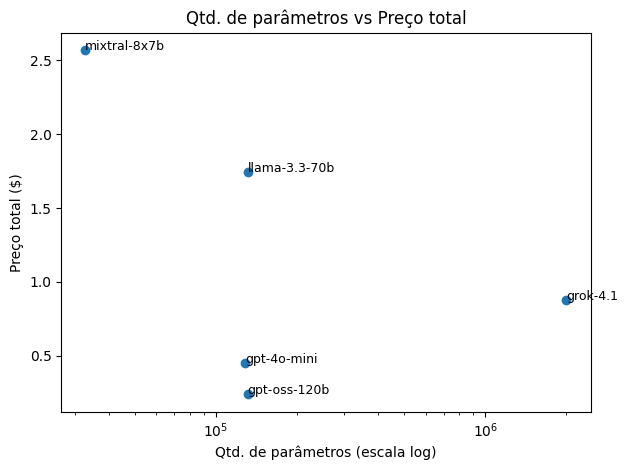

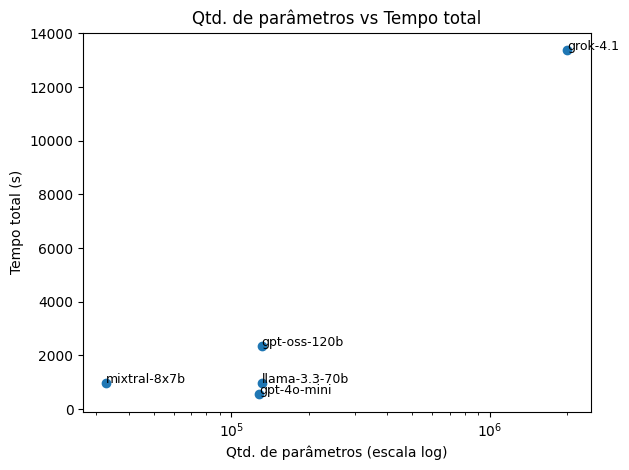

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# df = pd.read_csv("open_router_estatisticas.csv")  # se ainda não tiver carregado

mapa_nomes = {
    "x-ai/grok-4.1-fast": "grok-4.1",
    "openai/gpt-4o-mini": "gpt-4o-mini",
    "openai/gpt-oss-120b": "gpt-oss-120b",
    "meta-llama/llama-3.3-70b-instruct": "llama-3.3-70b",
    "mistralai/mixtral-8x7b-instruct": "mixtral-8x7b",  # (se quiser manter)
}

# Garantir numéricos
for col in ["parametros", "preco_total", "tempo_total_s", "tempo_total_ms"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df["tempo_total"] = df["tempo_total_s"]

# Criar nome curto (fallback: pega o que vem depois da barra)
df["modelo_curto"] = df["model_permaslug"].map(mapa_nomes)

base = df.dropna(subset=["parametros", "preco_total", "tempo_total"]).copy()

# -------------------------
# Gráfico: Parâmetros vs Preço total
# -------------------------
plt.figure()
plt.scatter(base["parametros"], base["preco_total"])

for _, r in base.iterrows():
    plt.annotate(r["modelo_curto"], (r["parametros"], r["preco_total"]), fontsize=9)

plt.xscale("log")
plt.xlabel("Qtd. de parâmetros (escala log)")
plt.ylabel("Preço total ($)")
plt.title("Qtd. de parâmetros vs Preço total")
plt.tight_layout()
plt.show()

# -------------------------
# Gráfico: Parâmetros vs Tempo total
# -------------------------
plt.figure()
plt.scatter(base["parametros"], base["tempo_total"])

for _, r in base.iterrows():
    plt.annotate(r["modelo_curto"], (r["parametros"], r["tempo_total"]), fontsize=9)

plt.xscale("log")
plt.xlabel("Qtd. de parâmetros (escala log)")
plt.ylabel(f"Tempo total ({unidade_tempo})")
plt.title("Qtd. de parâmetros vs Tempo total")
plt.tight_layout()
plt.show()

## 🔍 7. EXTRAÇÃO DO TRECHO DECISÓRIO VIA REGEX

### 7.1 Definição de Padrões de Decisão e Âncoras
**Descrição**: Padrões regex para identificar termos decisórios e âncoras textuais que marcam o início da parte dispositiva da sentença.

In [ ]:
import re

# 1) Decisões
padroes_decisao = re.compile(
    r"(?is)\b("
    r"julgo|"
    r"defiro|indefiro|"
    r"procedente|improcedente|"
    r"parcialmente\s+procedente|"
    r"extingo|"
    r"condeno|"
    r"homologo|"
    r"nego\s+provimento|dou\s+provimento|"
    r"rejeito|acolho"
    r")\b"
)

# 2) Âncoras para decisões
padroes_ancora = re.compile(
    r"(?im)\b("
    r"(?:do\s+)?dispositivo\b(?!s)|"
    r"ante\s+o\s+exposto|"
    r"isso\s+posto|isto\s+posto|"
    r"pelo\s+exposto|por\s+todo\s+o\s+exposto|"
    r"diante\s+disso|diante\s+do\s+exposto"
    r")\b"
)

### 7.2 Função de Extração do Trecho Decisório
**Descrição**: Extrai o trecho relevante da decisão judicial (dispositivo) usando âncoras textuais e padrões de decisão.

**Estratégia**:

1. Analisa apenas o final do documento (últimos 20.000 caracteres)
2. Prioridade: última âncora encontrada
3. Fallback: última semente de decisão
3. Fallback final: final do texto


**Justificativa**: O sentimento mais relevante está na parte decisória (dispositivo), não no relatório ou fundamentação.

In [ ]:
def extrair_trecho_decisao_simples(texto: str, n_chars: int = 4096, janela_back: int = 20000, lado: str = "inicio") -> str:
    """
    Retorna APENAS o trecho decisório.
    lado:
      - "inicio": pega os PRIMEIROS n_chars após âncora/decisão (ideal p/ 512)
      - "fim":    pega os ÚLTIMOS n_chars do trecho após âncora/decisão (ok p/ 4096)
    """
    if not isinstance(texto, str) or not texto.strip():
        return ""

    tail = texto[-janela_back:] if len(texto) > janela_back else texto
    offset = len(texto) - len(tail)

    start = None

    # 1) tenta âncora
    anc = list(padroes_ancora.finditer(tail))
    if anc:
        m = anc[-1]
        start = offset + m.end()
    else:
        # 2) tenta decisão
        dec = list(padroes_decisao.finditer(tail))
        if dec:
            m = dec[-1]
            start = offset + m.start()

    # 3) fallback
    if start is None:
        trecho = texto[-janela_back:]
    else:
        trecho = texto[start:]

    if lado == "fim":
        return trecho[-n_chars:].strip()
    else:  # "inicio"
        return trecho[:n_chars].strip()

### 7.3 Aplicação da Extração para Diferentes Tamanhos
**Descrição**: Extração de trechos decisórios em dois tamanhos diferentes:

* **512 caracteres**: Para modelos BERT padrão
* **4096 caracteres**: Para modelos Longformer

In [ ]:
df = pd.read_csv("decisoes_classificadas_cs_llm.csv", sep=";")

df["trecho_decisao_4096"] = df["decisao_completa"].astype(str).apply(
    lambda t: extrair_trecho_decisao_simples(t, n_chars=4096)
)

df["trecho_decisao_512"] = df["decisao_completa"].astype(str).apply(
    lambda t: extrair_trecho_decisao_simples(t, n_chars=512)
)

### 7.4 Verificação da Qualidade das Extrações
**Descrição**: Validação de que os trechos extraídos contêm palavras decisórias.

In [ ]:
df["trecho_tem_palavra_decisao_4096"] = df["trecho_decisao_4096"].apply(
    lambda s: bool(padroes_decisao.search(s)) if isinstance(s, str) else False
)

df["trecho_tem_palavra_decisao_512"] = df["trecho_decisao_512"].apply(
    lambda s: bool(padroes_decisao.search(s)) if isinstance(s, str) else False
)

# Porcentagens de qualidade
print(f"4096 - contém decisão: {(df['trecho_tem_palavra_decisao_4096'].mean() * 100):.2f} %")
print(f"512  - contém decisão: {(df['trecho_tem_palavra_decisao_512'].mean() * 100):.2f} %")
display(df.sample(5))

4096 - contém decisão: 94.68 %
512  - contém decisão: 91.76 %


,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,decisao_processada,sentimento_llm_mistral,sentimento_llm-gpt,sentimento_llm-gpt-mini,sentimento_llm-llama,sentimento_llm-deep-seek,sentimento_llm-grok,trecho_decisao_4096,trecho_decisao_512,trecho_tem_palavra_decisao_4096,trecho_tem_palavra_decisao_512
283,02026247420238060071.pdf,0202624-74.2023.8.06.0071,2ª Vara Cível da Comarca de Crato Rua Álvaro P...,Masculino,Masculino,Procedente,Vara Cível Comarca Crato Rua Álvaro Peixoto Sã...,EMPATICA,TECNICA,TECNICA,TECNICA,TECNICA,EMPATICA,"julgo PROCEDENTE a ação, e condeno a operadora...","julgo PROCEDENTE a ação, e condeno a operadora...",True,True
461,02370725520248060001.pdf,0237072-55.2024.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Masculino,Feminino,Procedente,Vara Infância Juventude Rua Desembargador Flor...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,", considerando tudo mais que dos autos consta,...",", considerando tudo mais que dos autos consta,...",True,True
468,02399837420238060001.pdf,0239983-74.2023.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Feminino,Masculino,Procedente,Vara Infância Juventude Rua Desembargador Flor...,EMPATICA,TECNICA,RIGOROSA,TECNICA,TECNICA,TECNICA,", requer o Município de Fortaleza seja julgado...",", requer o Município de Fortaleza seja julgado...",True,True
33,00504278020218060047.pdf,0050427-80.2021.8.06.0047,2ª Vara Cível da Comarca de Baturité Av. Ouvid...,Masculino,Masculino,Procedente,Vara Cível Comarca Baturité Ouvidor Mor Vitori...,EMPATICA,TECNICA,TECNICA,TECNICA,TECNICA,EMPATICA,Condeno o requerido ao pagamento de honorários...,Condeno o requerido ao pagamento de honorários...,True,True
289,02029337720248060001.pdf,0202933-77.2024.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Feminino,Masculino,Procedente,Vara Infância Juventude Rua Desembargador Flor...,EMPATICA,TECNICA,RIGOROSA,TECNICA,TECNICA,EMPATICA,", considerando tudo mais que dos autos consta,...",", considerando tudo mais que dos autos consta,...",True,True


### 7.5 Removendo colunas intermediárias

In [ ]:
df = df.drop(columns=["trecho_tem_palavra_decisao_4096", "trecho_tem_palavra_decisao_512"])

### 7.6 Verificando resultados

In [ ]:
display(df.sample(5))

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,decisao_processada,sentimento_llm_mistral,sentimento_llm-gpt,sentimento_llm-gpt-mini,sentimento_llm-llama,sentimento_llm-deep-seek,sentimento_llm-grok,trecho_decisao_4096,trecho_decisao_512
483,02420106420228060001.pdf,0242010-64.2022.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Feminino,Masculino,Procedente,Vara Infância Juventude Rua Desembargador Flor...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,", considerando tudo mais que dos autos consta,...",", considerando tudo mais que dos autos consta,..."
396,02213987120238060001.pdf,0221398-71.2023.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Masculino,Masculino,Procedente,Vara Infância Juventude Rua Desembargador Flor...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,máscara -valvulabolsa(ambu -reanimador manual)...,máscara -valvulabolsa(ambu -reanimador manual)...
422,02267073920248060001.pdf,0226707-39.2024.8.06.0001,3ª Vara da Infância e Juventude Rua Desembarga...,Feminino,Feminino,Procedente,Vara Infância Juventude Rua Desembargador Flor...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,", considerando tudo mais que dos autos consta,...",", considerando tudo mais que dos autos consta,..."
598,02587899420228060001.pdf,0258789-94.2022.8.06.0001,31ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Feminino,Masculino,Improcedente,31ª Vara Cível SEJUD Grau Rua Desembargador Fl...,TECNICA,TECNICA,RIGOROSA,TECNICA,TECNICA,EMPATICA,", EXTINGO O FEITO COM RESOLUÇÃO DE MÉRITO, nos...",", EXTINGO O FEITO COM RESOLUÇÃO DE MÉRITO, nos..."
589,02572188820228060001.pdf,0257218-88.2022.8.06.0001,19ª Vara Cível (SEJUD 1º Grau) Rua Desembargad...,Feminino,Masculino,Procedente,19ª Vara Cível SEJUD Grau Rua Desembargador Fl...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,", julgo PROCEDENTE o pleito autoral, com fulcr...",", julgo PROCEDENTE o pleito autoral, com fulcr..."


### 7.7 Salvando resultados

In [ ]:
df.to_csv("decisoes_classificadas_cs_llm_regex.csv", index=False, sep=";")

## 💬 8. ANÁLISE DE SENTIMENTO COM BERT e RoBERTa

### 8.1 Carregamento dos Modelos BERT e RoBERTa
**Descrição**: Modelo BERT fine-tuned para análise de sentimento (512 tokens) em avaliações de produtos em 6 idiomas (incluindo português). Prediz sentimento em escala de 1 a 5 estrelas. Modelo RoBERTa que contém maior janela de tokens para análise (4096 tokens).

**Hugging Face** 🤗:
* BERT: https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
* RoBERTa: https://huggingface.co/markussagen/xlm-roberta-longformer-base-4096

In [ ]:
!pip uninstall -y transformers tokenizers huggingface-hub safetensors
!pip install -U --no-cache-dir "transformers==4.56.2" "tokenizers==0.22.1" "huggingface-hub==0.35.3" "safetensors>=0.4.3"

from transformers import pipeline

bert_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    truncation=True,
    max_length=512
  )

Found existing installation: transformers 4.57.0
Uninstalling transformers-4.57.0:
  Successfully uninstalled transformers-4.57.0
Found existing installation: tokenizers 0.22.1
Uninstalling tokenizers-0.22.1:
  Successfully uninstalled tokenizers-0.22.1
Found existing installation: huggingface-hub 0.35.3
Uninstalling huggingface-hub-0.35.3:
  Successfully uninstalled huggingface-hub-0.35.3
Found existing installation: safetensors 0.6.2
Uninstalling safetensors-0.6.2:
  Successfully uninstalled safetensors-0.6.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 134.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 301.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 400.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 392.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.2/507.2 kB 379.7 MB/s eta 0:00:00


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
roberta_pipeline = pipeline(
    "sentiment-analysis",
    model="markussagen/xlm-roberta-longformer-base-4096",
    truncation=True,
    max_length=4096
  )

config.json:   0%|          | 0.00/773 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at markussagen/xlm-roberta-longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


### 8.2 Testando análise de sentimentos antes de prosseguir para o dataset completo

In [ ]:
textos_teste = [
    # Texto 1 – Empático / Procedente
    "Diante da vulnerabilidade da parte autora e da comprovada necessidade do medicamento, "
    " procedente o pedido, assegurando o direito fundamental à saúde.",

    # Texto 2 – Rigoroso / Improcedente
    "Não restou comprovado o direito alegado. Ausente prova mínima dos fatos constitutivos, "
    "julgo improcedente o pedido, nos termos da legislação vigente."
]

# BERT (512)
saida_bert = bert_pipeline(textos_teste)

# RoBERTa Longformer (4096)
saida_roberta = roberta_pipeline(textos_teste)

print("=== BERT ===")
for t, s in zip(textos_teste, saida_bert):
    print("\nTexto:", t)
    print("Saída:", s)

print("\n=== RoBERTa ===")
for t, s in zip(textos_teste, saida_roberta):
    print("\nTexto:", t)
    print("Saída:", s)


=== BERT ===

Texto: Diante da vulnerabilidade da parte autora e da comprovada necessidade do medicamento,  procedente o pedido, assegurando o direito fundamental à saúde.
Saída: {'label': '5 stars', 'score': 0.2671985328197479}

Texto: Não restou comprovado o direito alegado. Ausente prova mínima dos fatos constitutivos, julgo improcedente o pedido, nos termos da legislação vigente.
Saída: {'label': '1 star', 'score': 0.5797569155693054}

=== RoBERTa ===

Texto: Diante da vulnerabilidade da parte autora e da comprovada necessidade do medicamento,  procedente o pedido, assegurando o direito fundamental à saúde.
Saída: {'label': 'LABEL_0', 'score': 0.6176493167877197}

Texto: Não restou comprovado o direito alegado. Ausente prova mínima dos fatos constitutivos, julgo improcedente o pedido, nos termos da legislação vigente.
Saída: {'label': 'LABEL_0', 'score': 0.6198321580886841}


### 8.3 Conclusão sobre testes realizados acima
**Descrição**: Os testes indicaram que, embora utilize rótulos genéricos de sentimento, o modelo BERT apresentou respostas coerentes com a polaridade dos textos analisados. Já o RoBERTa não distinguiu adequadamente textos semanticamente distintos, por conta disso, continuaremos somente com as análises do modelo BERT.

### 8.4 Funções Auxiliares para Processamento em Batch
**Descrição**: Função para processar múltiplos textos em batches, otimizando performance.

In [ ]:
def _rodar_pipeline_em_batch(textos, pipe, batch_size=8):
    """
    Roda pipeline em batches e retorna lista de dicts [{'label':..., 'score':...}, ...]
    Mantém alinhamento com a lista de entrada.
    """
    textos = list(textos)
    out = []
    for i in range(0, len(textos), batch_size):
        batch = textos[i:i+batch_size]
        # garante string
        batch = ["" if (not isinstance(t, str)) else t for t in batch]
        preds = pipe(batch)
        out.extend(preds)
    return out

### 8.5 Funções de Transformação de Resultados
**Descrição**: Conversão dos labels do BERT (1-5 stars) para categorias interpretáveis.

**Mapeamento**:

* 1-2 stars → RIGOROSA (linguagem restritiva, negativa)
* 3 stars → TECNICA (linguagem neutra, formal)
* 4-5 stars → EMPATICA (linguagem favorável, acolhedora)

In [ ]:
def bert_label_to_int(label: str):
    # '1 star'...'5 stars' -> 1..5
    import re
    m = re.search(r"(\d)", label)
    return int(m.group(1))

def map_1_5_to_sentimento(valor_1_5: float):
    """
    Mapeamento simples p/ ficar comparável com LLM:
    1-2 -> RIGOROSA
    3   -> TECNICA
    4-5 -> EMPATICA
    """
    v = int(valor_1_5)
    if v <= 2:
        return "RIGOROSA"
    elif v == 3:
        return "TECNICA"
    else:
        return "EMPATICA"

### 8.6 Aplicação do BERT no Dataset Completo
**Descrição**: Análise de sentimento em todos os trechos decisórios de 512 caracteres.

In [ ]:
import pandas as pd
df = pd.read_csv("decisoes_classificadas_cs_llm_regex.csv", sep=";")

# --- BERT (512) ---
preds_bert = _rodar_pipeline_em_batch(
    df["trecho_decisao_512"].tolist(),
    bert_pipeline,
    batch_size=16
)

df["analise_bert_label"] = [p.get("label") for p in preds_bert]
df["analise_bert_1a5"] = df["analise_bert_label"].apply(bert_label_to_int)
df["analise_bert"] = df["analise_bert_1a5"].apply(map_1_5_to_sentimento)

### 8.7 Verificando resultados

In [ ]:
display(df.head(5))

,arquivo,numero_processo,decisao_completa,genero_juiz,genero_parte,resultado_sentenca,decisao_processada,sentimento_llm_mistral,sentimento_llm-gpt,sentimento_llm-gpt-mini,sentimento_llm-llama,sentimento_llm-deep-seek,sentimento_llm-grok,trecho_decisao_4096,trecho_decisao_512,analise_bert_label,analise_bert_1a5,analise_bert
0,00004983720188060127.pdf,0000498-37.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Feminino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,", com fulcro no art. 487, I do CPC julgo PROCE...",", com fulcro no art. 487, I do CPC julgo PROCE...",1 star,1,RIGOROSA
1,00006188020188060127.pdf,0000618-80.2018.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,ERRO,EMPATICA,EMPATICA,EMPATICA,EMPATICA,", com fulcro no art. 487, I do CPC julgo PROCE...",", com fulcro no art. 487, I do CPC julgo PROCE...",1 star,1,RIGOROSA
2,00009657920198060127.pdf,0000965-79.2019.8.06.0127,"PRAÇA LUIZ ALVES DE MESQUITA, S/N, CENTRO - CE...",Feminino,Masculino,Procedente,PRAÇA LUIZ ALVES MESQUITA CENTRO CEP 63780 000...,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,EMPATICA,", com fulcro no art. 487, I do CPC julgo PROCE...",", com fulcro no art. 487, I do CPC julgo PROCE...",1 star,1,RIGOROSA
3,00013144420188060151.pdf,0001314-44.2018.8.06.0151,"1ª Vara da Comarca de Quixadá Av. Jesus, Maria...",Masculino,Masculino,Improcedente,Vara Comarca Quixadá Jesus Maria José Jardim M...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,", confirmo os efeitos da tutela de urgência pa...",", confirmo os efeitos da tutela de urgência pa...",1 star,1,RIGOROSA
4,00018334020188060047.pdf,0001833-40.2018.8.06.0047,1ª Vara da Comarca de Baturité Av. Ouvidor Mor...,Masculino,Masculino,Procedente,Vara Comarca Baturité Ouvidor Mor Vitoriano So...,EMPATICA,TECNICA,EMPATICA,TECNICA,TECNICA,EMPATICA,", nos termos do art. 487, inciso I, do CPC, JU...",", nos termos do art. 487, inciso I, do CPC, JU...",1 star,1,RIGOROSA


### 8.8 Gerando análise entre resultados

In [ ]:
import pandas as pd
import numpy as np

SENT_VALIDOS = {"EMPATICA", "TECNICA", "RIGOROSA"}

MODELOS_SENTIMENTO = {
    "BERT": "analise_bert",
    "mistralai/mixtral-8x7b-instruct": "sentimento_llm_mistral",
    "openai/gpt-oss-120b": "sentimento_llm-gpt",
    "openai/gpt-4o-mini": "sentimento_llm-gpt-mini",
    "meta-llama/llama-3.3-70b-instruct": "sentimento_llm-llama",
    "deepseek/deepseek-v3.2": "sentimento_llm-deep-seek",
    "x-ai/grok-4.1-fast": "sentimento_llm-grok",
}

def tabela_sentimento_resultado_juiz_parte(df, col_modelo):
    """
    Tabela detalhada por:
      resultado × sentimento × genero_juiz × genero_parte

    Retorna:
      - valor_absoluto
      - percentual_total (sobre total válido do modelo)
      - percentual_dentro_resultado (soma 100% dentro de Procedente/Improcedente)
      - percentual_dentro_resultado_sentimento (soma 100% dentro de cada resultado+sentimento)
    """
    tmp = df.copy()

    # normaliza e filtra sentimento válido
    tmp["sentimento"] = tmp[col_modelo].astype(str).str.strip().str.upper()
    tmp = tmp[tmp["sentimento"].isin(SENT_VALIDOS)].copy()

    # resultado limpo
    tmp["resultado"] = tmp["resultado_sentenca"].astype(str).str.strip()

    # ---- Contagem base: resultado x sentimento x juiz x parte ----
    tab = (
        tmp
        .groupby(["resultado", "sentimento", "genero_juiz", "genero_parte"])
        .size()
        .rename("valor_absoluto")
        .reset_index()
    )

    # ---- Percentual do total válido do modelo ----
    total_validos = tab["valor_absoluto"].sum()
    tab["percentual_total"] = (tab["valor_absoluto"] / total_validos * 100) if total_validos else 0

    # ---- Percentual dentro do resultado (Procedente / Improcedente) ----
    denom_resultado = tab.groupby("resultado")["valor_absoluto"].transform("sum").replace(0, np.nan)
    tab["percentual_dentro_resultado"] = (tab["valor_absoluto"] / denom_resultado * 100).fillna(0)

    # ---- Percentual dentro de (resultado + sentimento) ----
    denom_rs = tab.groupby(["resultado", "sentimento"])["valor_absoluto"].transform("sum").replace(0, np.nan)
    tab["percentual_dentro_resultado_sentimento"] = (tab["valor_absoluto"] / denom_rs * 100).fillna(0)

    # ---- Ordenação amigável ----
    tab["resultado"] = pd.Categorical(tab["resultado"], categories=["Procedente", "Improcedente"], ordered=True)
    tab["sentimento"] = pd.Categorical(tab["sentimento"], categories=["RIGOROSA", "TECNICA", "EMPATICA"], ordered=True)
    tab["genero_juiz"] = pd.Categorical(tab["genero_juiz"], categories=["Masculino", "Feminino"], ordered=True)
    tab["genero_parte"] = pd.Categorical(tab["genero_parte"], categories=["Masculino", "Feminino"], ordered=True)

    tab = tab.sort_values(["resultado", "sentimento", "genero_juiz", "genero_parte"]).reset_index(drop=True)

    return tab

# --- Rodar para todos os modelos ---
resultados_detalhados = {}

for nome_modelo, col_modelo in MODELOS_SENTIMENTO.items():
    out = tabela_sentimento_resultado_juiz_parte(df, col_modelo)
    resultados_detalhados[nome_modelo] = out

    print("\n" + "="*100)
    print(f"Modelo: {nome_modelo} | Coluna: {col_modelo}")
    print("="*100)
    display(out)


Modelo: BERT | Coluna: analise_bert


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,RIGOROSA,Masculino,Masculino,124,16.489362,23.005566,25.254582
1,Procedente,RIGOROSA,Masculino,Feminino,145,19.281915,26.901670,29.531568
2,Procedente,RIGOROSA,Feminino,Masculino,121,16.090426,22.448980,24.643585
3,Procedente,RIGOROSA,Feminino,Feminino,101,13.430851,18.738404,20.570265
4,Procedente,TECNICA,Masculino,Masculino,2,0.265957,0.371058,25.000000
5,Procedente,TECNICA,Masculino,Feminino,5,0.664894,0.927644,62.500000
6,Procedente,TECNICA,Feminino,Feminino,1,0.132979,0.185529,12.500000
7,Procedente,EMPATICA,Masculino,Masculino,13,1.728723,2.411874,32.500000
8,Procedente,EMPATICA,Masculino,Feminino,20,2.659574,3.710575,50.000000
9,Procedente,EMPATICA,Feminino,Masculino,5,0.664894,0.927644,12.500000



Modelo: mistralai/mixtral-8x7b-instruct | Coluna: sentimento_llm_mistral


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,TECNICA,Masculino,Masculino,19,2.526596,3.525046,51.351351
1,Procedente,TECNICA,Masculino,Feminino,13,1.728723,2.411874,35.135135
2,Procedente,TECNICA,Feminino,Masculino,4,0.531915,0.742115,10.810811
3,Procedente,TECNICA,Feminino,Feminino,1,0.132979,0.185529,2.702703
4,Procedente,EMPATICA,Masculino,Masculino,120,15.957447,22.263451,23.904382
5,Procedente,EMPATICA,Masculino,Feminino,157,20.877660,29.128015,31.274900
6,Procedente,EMPATICA,Feminino,Masculino,122,16.223404,22.634508,24.302789
7,Procedente,EMPATICA,Feminino,Feminino,103,13.696809,19.109462,20.517928
8,Improcedente,TECNICA,Masculino,Masculino,16,2.127660,7.511737,30.769231
9,Improcedente,TECNICA,Masculino,Feminino,22,2.925532,10.328638,42.307692



Modelo: openai/gpt-oss-120b | Coluna: sentimento_llm-gpt


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,TECNICA,Masculino,Masculino,134,17.986577,25.140713,26.070039
1,Procedente,TECNICA,Masculino,Feminino,161,21.610738,30.206379,31.322957
2,Procedente,TECNICA,Feminino,Masculino,121,16.241611,22.701689,23.540856
3,Procedente,TECNICA,Feminino,Feminino,98,13.154362,18.386492,19.066148
4,Procedente,EMPATICA,Masculino,Masculino,5,0.671141,0.938086,26.315789
5,Procedente,EMPATICA,Masculino,Feminino,6,0.805369,1.125704,31.578947
6,Procedente,EMPATICA,Feminino,Masculino,2,0.268456,0.375235,10.526316
7,Procedente,EMPATICA,Feminino,Feminino,6,0.805369,1.125704,31.578947
8,Improcedente,RIGOROSA,Feminino,Masculino,1,0.134228,0.471698,100.000000
9,Improcedente,TECNICA,Masculino,Masculino,45,6.040268,21.226415,21.634615



Modelo: openai/gpt-4o-mini | Coluna: sentimento_llm-gpt-mini


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,RIGOROSA,Masculino,Masculino,9,1.196809,1.669759,18.367347
1,Procedente,RIGOROSA,Masculino,Feminino,10,1.329787,1.855288,20.408163
2,Procedente,RIGOROSA,Feminino,Masculino,17,2.260638,3.153989,34.693878
3,Procedente,RIGOROSA,Feminino,Feminino,13,1.728723,2.411874,26.530612
4,Procedente,TECNICA,Masculino,Masculino,50,6.648936,9.276438,37.878788
5,Procedente,TECNICA,Masculino,Feminino,67,8.909574,12.430427,50.757576
6,Procedente,TECNICA,Feminino,Masculino,9,1.196809,1.669759,6.818182
7,Procedente,TECNICA,Feminino,Feminino,6,0.797872,1.113173,4.545455
8,Procedente,EMPATICA,Masculino,Masculino,80,10.638298,14.842301,22.346369
9,Procedente,EMPATICA,Masculino,Feminino,93,12.367021,17.254174,25.977654



Modelo: meta-llama/llama-3.3-70b-instruct | Coluna: sentimento_llm-llama


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,TECNICA,Masculino,Masculino,135,17.952128,25.046382,27.272727
1,Procedente,TECNICA,Masculino,Feminino,151,20.079787,28.014842,30.505051
2,Procedente,TECNICA,Feminino,Masculino,116,15.425532,21.521336,23.434343
3,Procedente,TECNICA,Feminino,Feminino,93,12.367021,17.254174,18.787879
4,Procedente,EMPATICA,Masculino,Masculino,4,0.531915,0.742115,9.090909
5,Procedente,EMPATICA,Masculino,Feminino,19,2.526596,3.525046,43.181818
6,Procedente,EMPATICA,Feminino,Masculino,10,1.329787,1.855288,22.727273
7,Procedente,EMPATICA,Feminino,Feminino,11,1.462766,2.040816,25.000000
8,Improcedente,TECNICA,Masculino,Masculino,46,6.117021,21.596244,21.596244
9,Improcedente,TECNICA,Masculino,Feminino,58,7.712766,27.230047,27.230047



Modelo: deepseek/deepseek-v3.2 | Coluna: sentimento_llm-deep-seek


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,TECNICA,Masculino,Masculino,136,18.085106,25.231911,27.309237
1,Procedente,TECNICA,Masculino,Feminino,152,20.212766,28.200371,30.522088
2,Procedente,TECNICA,Feminino,Masculino,118,15.691489,21.892393,23.694779
3,Procedente,TECNICA,Feminino,Feminino,92,12.234043,17.068646,18.473896
4,Procedente,EMPATICA,Masculino,Masculino,3,0.398936,0.556586,7.317073
5,Procedente,EMPATICA,Masculino,Feminino,18,2.393617,3.339518,43.902439
6,Procedente,EMPATICA,Feminino,Masculino,8,1.063830,1.484230,19.512195
7,Procedente,EMPATICA,Feminino,Feminino,12,1.595745,2.226345,29.268293
8,Improcedente,TECNICA,Masculino,Masculino,46,6.117021,21.596244,21.596244
9,Improcedente,TECNICA,Masculino,Feminino,58,7.712766,27.230047,27.230047



Modelo: x-ai/grok-4.1-fast | Coluna: sentimento_llm-grok


,resultado,sentimento,genero_juiz,genero_parte,valor_absoluto,percentual_total,percentual_dentro_resultado,percentual_dentro_resultado_sentimento
0,Procedente,TECNICA,Masculino,Masculino,36,4.787234,6.679035,25.352113
1,Procedente,TECNICA,Masculino,Feminino,43,5.718085,7.977737,30.281690
2,Procedente,TECNICA,Feminino,Masculino,37,4.920213,6.864564,26.056338
3,Procedente,TECNICA,Feminino,Feminino,26,3.457447,4.823748,18.309859
4,Procedente,EMPATICA,Masculino,Masculino,103,13.696809,19.109462,25.944584
5,Procedente,EMPATICA,Masculino,Feminino,127,16.888298,23.562152,31.989924
6,Procedente,EMPATICA,Feminino,Masculino,89,11.835106,16.512059,22.418136
7,Procedente,EMPATICA,Feminino,Feminino,78,10.372340,14.471243,19.647355
8,Improcedente,RIGOROSA,Masculino,Masculino,4,0.531915,1.877934,80.000000
9,Improcedente,RIGOROSA,Feminino,Masculino,1,0.132979,0.469484,20.000000


### 8.8 Baixando resultados parciais

In [ ]:
df.to_csv("decisoes_classificadas_cs_llm_bert.csv", index=False, sep=";")

## 📊 9. VISUALIZAÇÕES E ANÁLISE EXPLORATÓRIA

### 9.1 Leitura do Dataset + Configuração de Cores e Ordenações
**Descrição**: Definição de cores semânticas e ordenações para visualizações consistentes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("decisoes_classificadas_cs_llm_bert.csv", sep=";")

CORES = {
    "RIGOROSA": "#b22222",  # vermelho escuro
    "TECNICA":  "#808080",  # cinza
    "EMPATICA": "#2e8b57",  # verde
}

ORDEM_SENTIMENTO = ["RIGOROSA", "TECNICA", "EMPATICA"]

ORDEM_CATEGORIA = [
    "Juiz homem / Parte homem",
    "Juiz homem / Parte mulher",
    "Juiz mulher / Parte homem",
    "Juiz mulher / Parte mulher",
]


### 9.2 Funções de Normalização (Gênero e Sentimento)

In [ ]:
def norm_genero(x):
    if pd.isna(x):
        return None
    s = str(x).strip().lower()
    if "masc" in s or s in {"m", "homem", "male"}:
        return "homem"
    if "fem" in s or s in {"f", "mulher", "female"}:
        return "mulher"
    return None

def norm_sentimento(x):
    if pd.isna(x):
        return None
    s = str(x).strip().upper()

    # mantém o padrão do projeto
    if s in {"RIGOROSA", "TECNICA", "EMPATICA"}:
        return s

    # casos ruins/erro (ex.: GPT pode ter "ERRO")
    if s in {"ERRO", "ERROR", "NONE", "NAN", ""}:
        return None

    return None

### 9.3 Geração de Gráficos (por resultado e por modelo)

In [ ]:
def plot_8_barras_empilhadas(df, col_sentimento, nome_modelo=None, percentual=False,
                            mostrar_labels=True, min_label_abs=3, min_label_pct=5):
    """
    8 barras empilhadas por sentimento.
    Se mostrar_labels=True, escreve rótulos dentro de cada segmento.
      - absoluto: mostra se valor >= min_label_abs
      - percentual: mostra se valor >= min_label_pct (em %)
    """
    nome = nome_modelo or col_sentimento

    tmp = df.copy()
    tmp["resultado"] = tmp["resultado_sentenca"].astype(str).str.strip()
    tmp = tmp[tmp["resultado"].isin(["Procedente", "Improcedente"])].copy()

    tmp["sent"] = tmp[col_sentimento].apply(norm_sentimento)
    tmp = tmp[tmp["sent"].isin(ORDEM_SENTIMENTO)].copy()

    tmp["juiz"] = tmp["genero_juiz"].apply(norm_genero)
    tmp["parte"] = tmp["genero_parte"].apply(norm_genero)
    tmp = tmp[tmp["juiz"].isin(["homem", "mulher"]) & tmp["parte"].isin(["homem", "mulher"])].copy()

    MAP_RES = {"Procedente": "P", "Improcedente": "I"}
    MAP_J = {"homem": "JH", "mulher": "JM"}
    MAP_P = {"homem": "PH", "mulher": "PM"}

    tmp["label_x"] = (
        tmp["resultado"].map(MAP_RES) + " | " +
        tmp["juiz"].map(MAP_J) + " | " +
        tmp["parte"].map(MAP_P)
    )

    ordem_x = [
        "P | JH | PH", "P | JH | PM", "P | JM | PH", "P | JM | PM",
        "I | JH | PH", "I | JH | PM", "I | JM | PH", "I | JM | PM",
    ]

    tab = (
        tmp.pivot_table(
            index="label_x",
            columns="sent",
            values="numero_processo",
            aggfunc=pd.Series.nunique,
            fill_value=0
        )
        .reindex(ordem_x, fill_value=0)
    )

    for s in ORDEM_SENTIMENTO:
        if s not in tab.columns:
            tab[s] = 0
    tab = tab[ORDEM_SENTIMENTO]

    if percentual:
        tab_plot = tab.div(tab.sum(axis=1).replace(0, np.nan), axis=0) * 100
        tab_plot = tab_plot.fillna(0)
        ylabel = "Percentual de processos (%)"
        titulo = f"{nome} — Percentual (100% empilhado) — 8 barras"
    else:
        tab_plot = tab
        ylabel = "Quantidade de processos"
        titulo = f"{nome} — Contagem — 8 barras"

    x = np.arange(len(tab_plot.index))
    bottom = np.zeros(len(tab_plot.index))

    plt.figure(figsize=(14, 6))

    for s in ORDEM_SENTIMENTO:
        vals = tab_plot[s].values
        bars = plt.bar(x, vals, bottom=bottom, label=s, color=CORES[s])

        if mostrar_labels:
            for i, (bar, v) in enumerate(zip(bars, vals)):
                if percentual:
                    if v >= min_label_pct:
                        y_text = bottom[i] + v / 2
                        plt.text(
                            bar.get_x() + bar.get_width()/2, y_text, f"{v:.0f}%",
                            ha="center", va="center", fontsize=9,
                            color="white", fontweight="bold"
                        )
                else:
                    if v >= min_label_abs:
                        y_text = bottom[i] + v / 2
                        plt.text(
                            bar.get_x() + bar.get_width()/2, y_text, f"{int(v)}",
                            ha="center", va="center", fontsize=9,
                            color="white", fontweight="bold"
                        )

        bottom += vals

    plt.xticks(x, tab_plot.index, rotation=20, ha="right")
    plt.ylabel(ylabel)
    if percentual:
        plt.ylim(0, 100)
    plt.title(titulo)
    plt.legend(title="Sentimento")
    plt.tight_layout()
    plt.show()

    return tab

### 9.4 Criando dicionário chave:valor MODELOS

In [ ]:
MODELOS = {
    "BERT (512)": "analise_bert",
    "mistralai/mixtral-8x7b-instruct": "sentimento_llm_mistral",
    "openai/gpt-oss-120b": "sentimento_llm-gpt",
    "openai/gpt-4o-mini": "sentimento_llm-gpt-mini",
    "meta-llama/llama-3.3-70b-instruct": "sentimento_llm-llama",
    "deepseek/deepseek-v3.2": "sentimento_llm-deep-seek",
    "x-ai/grok-4.1-fast": "sentimento_llm-grok",
}

### 9.5 Gerando gráficos empilhados para cada um dos modelos

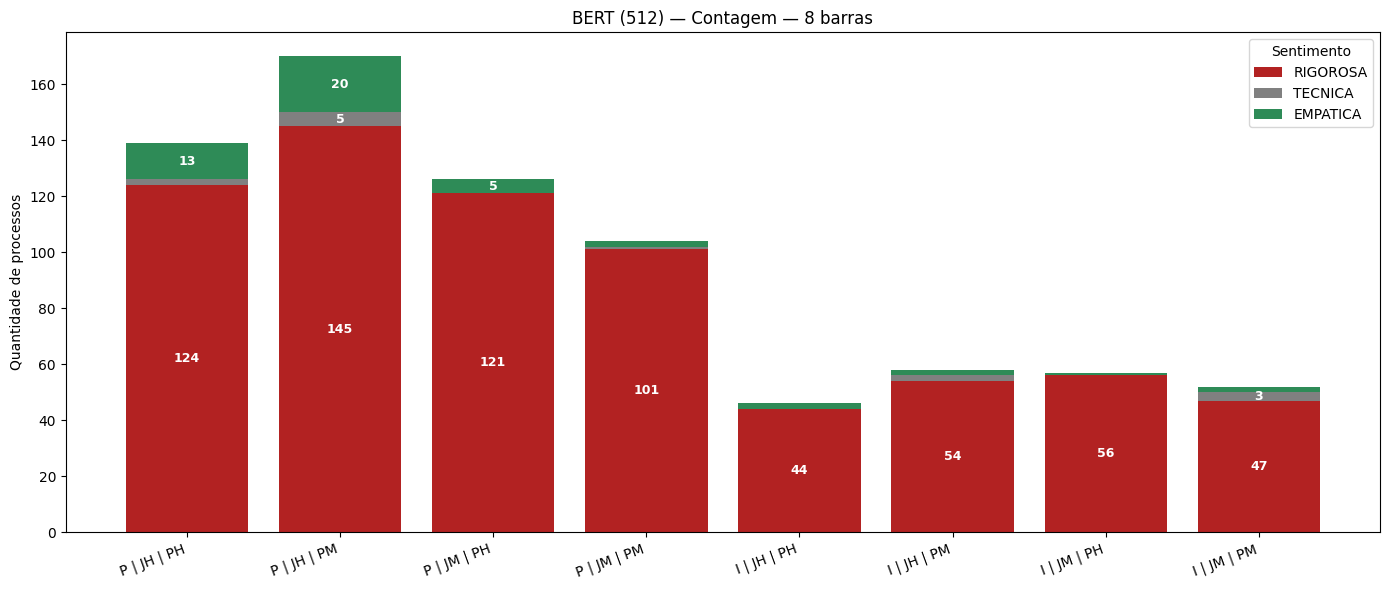

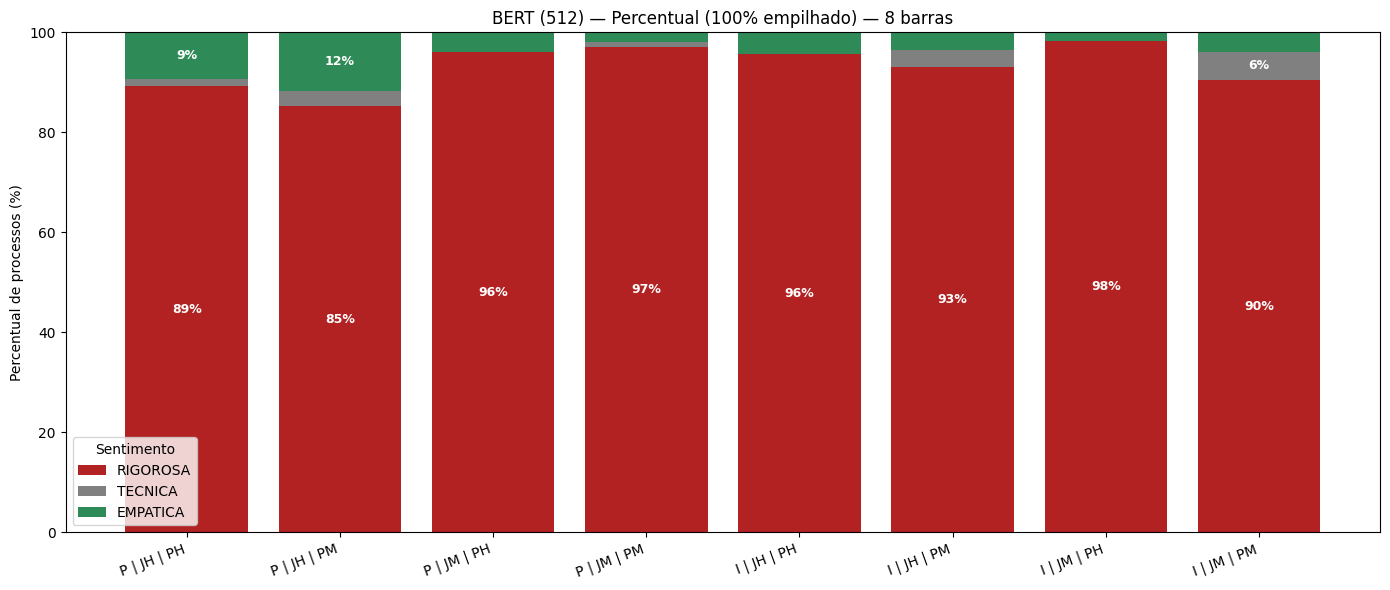

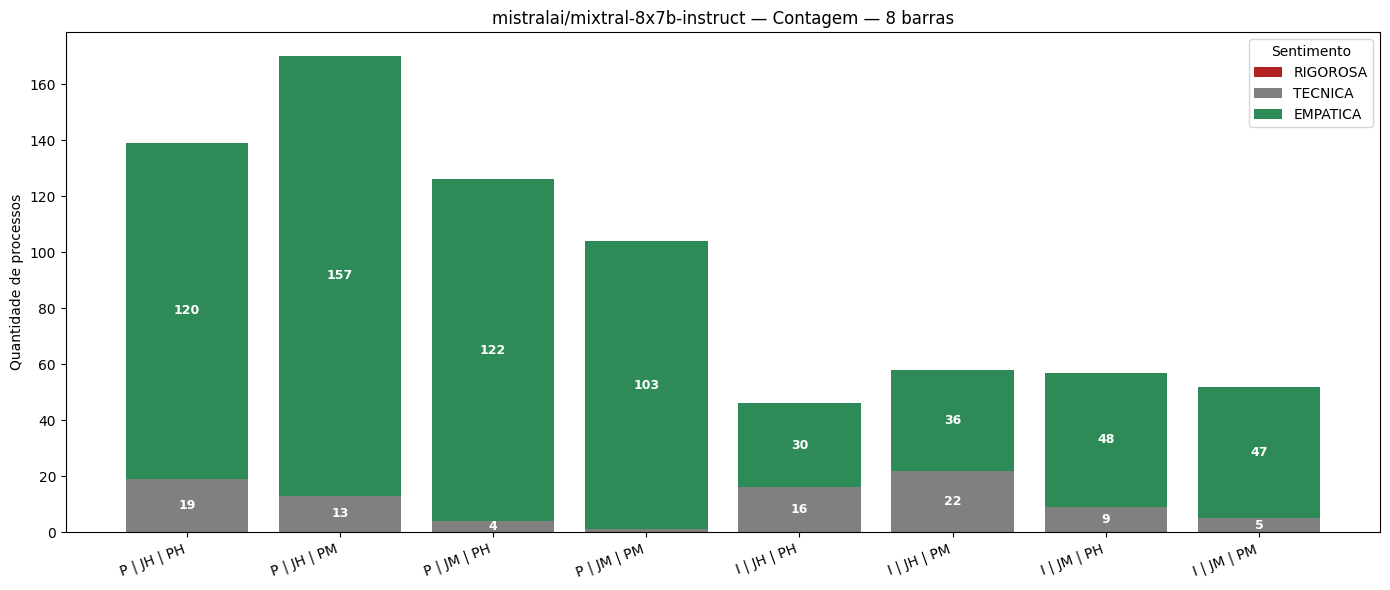

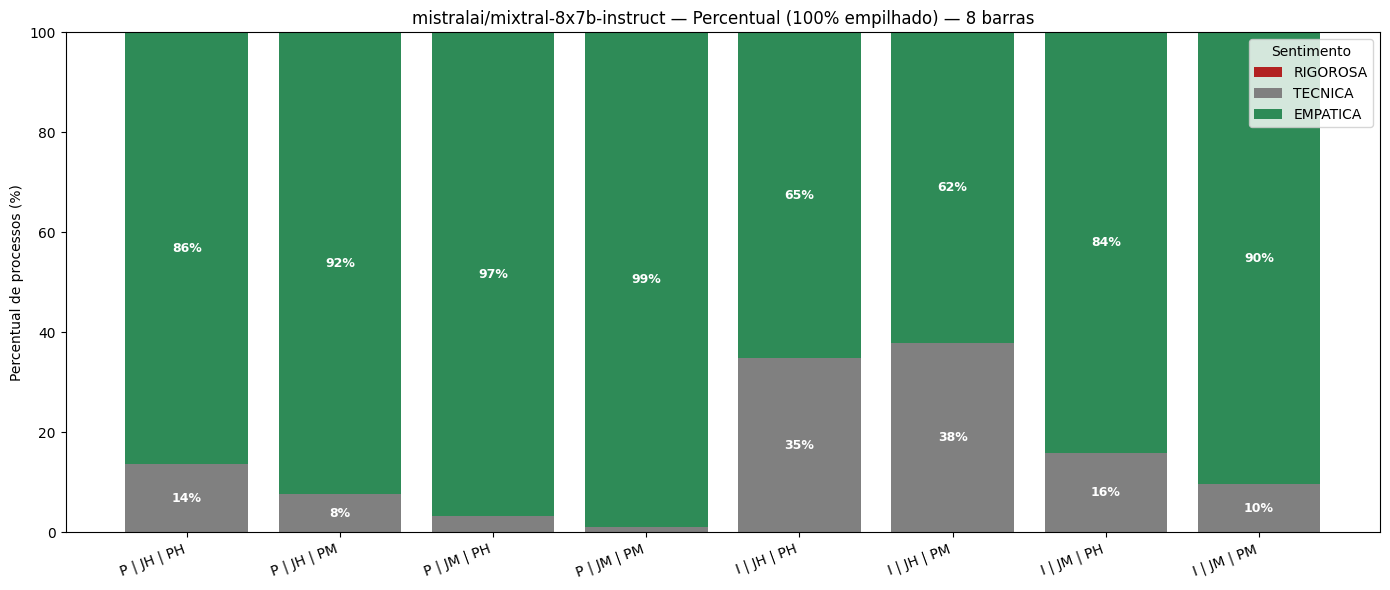

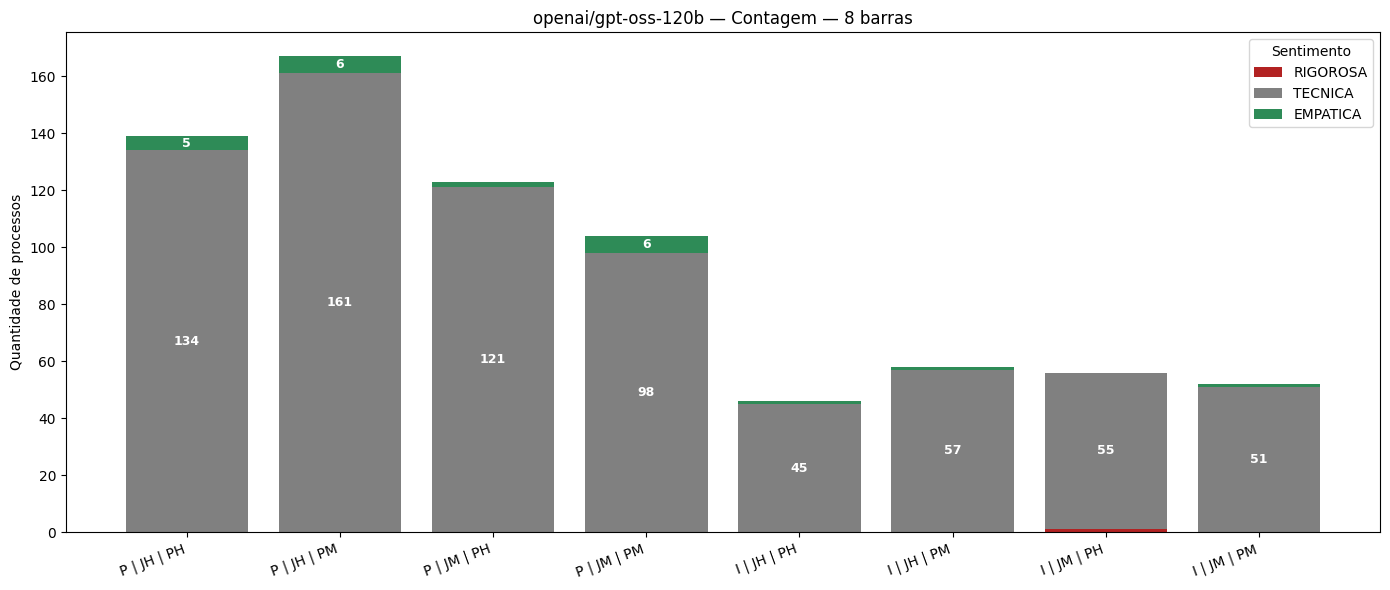

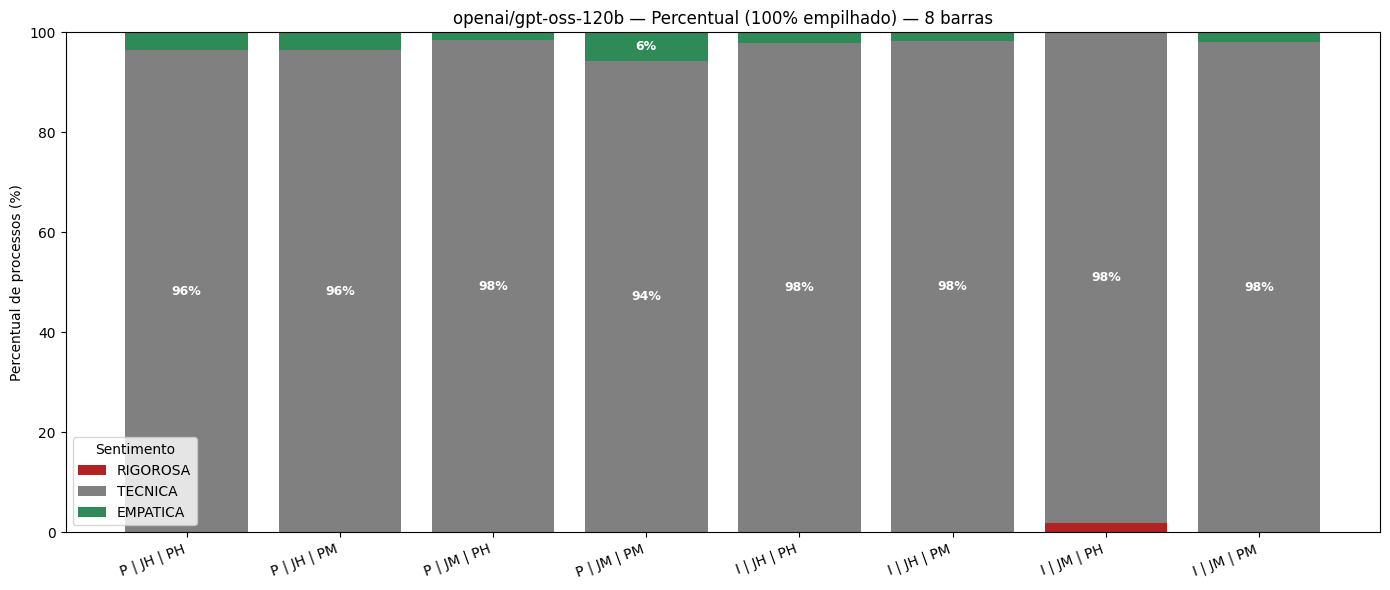

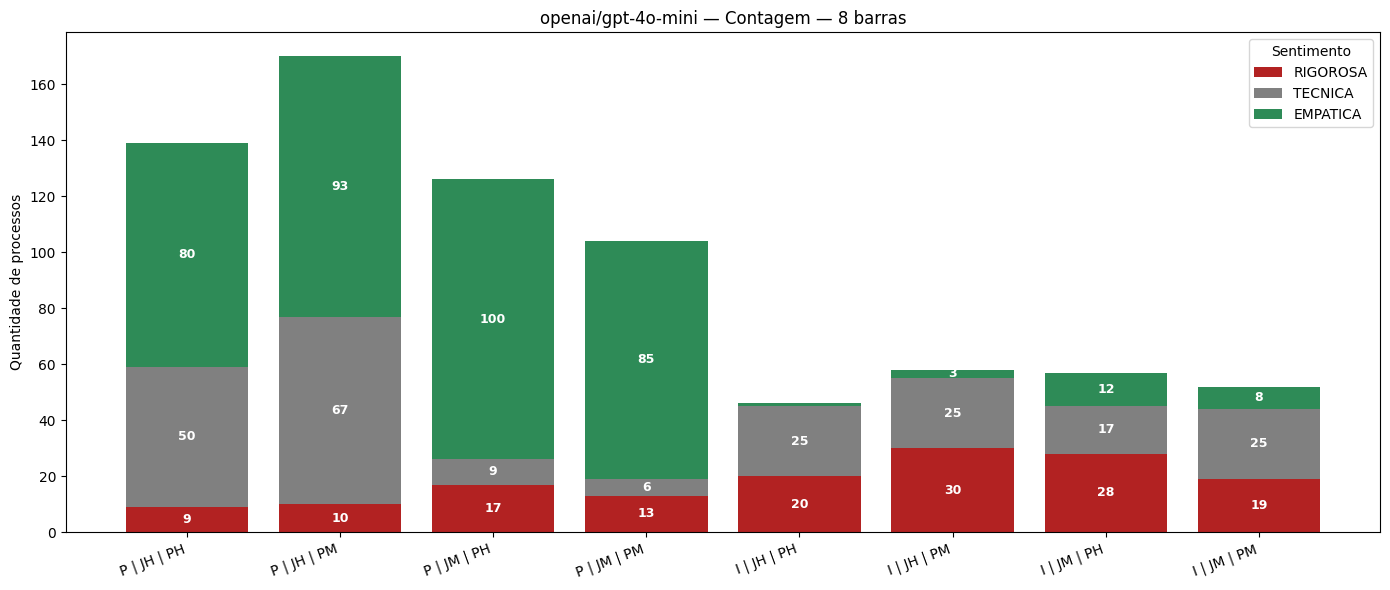

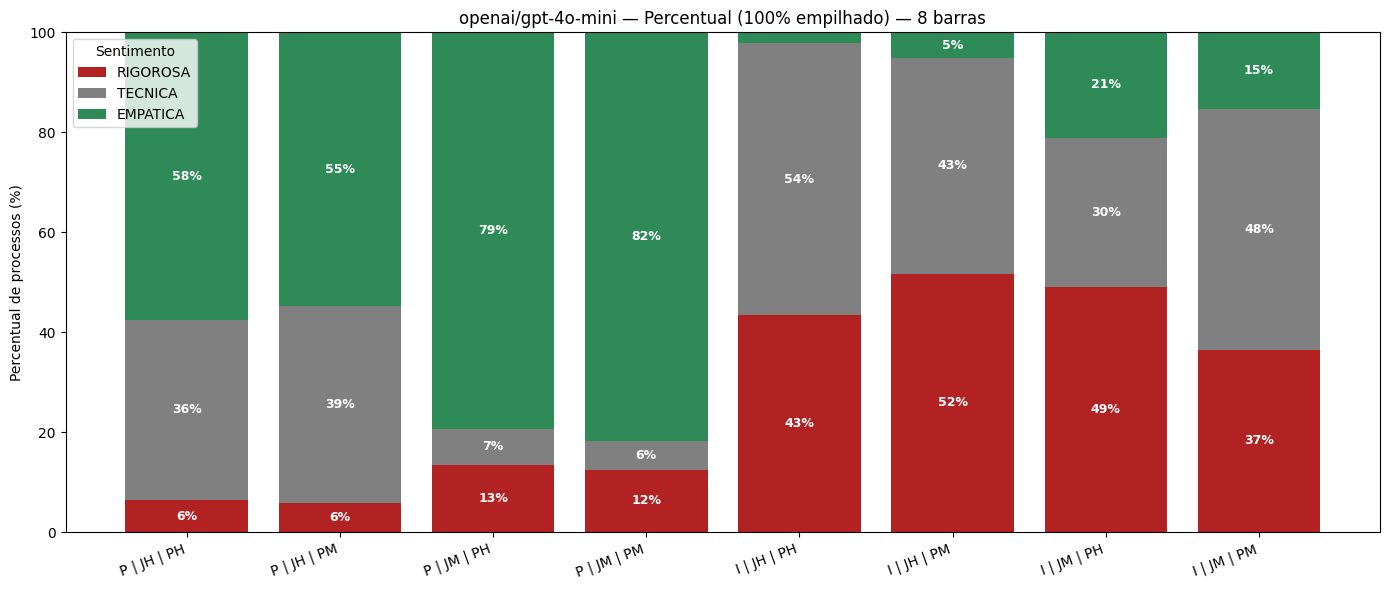

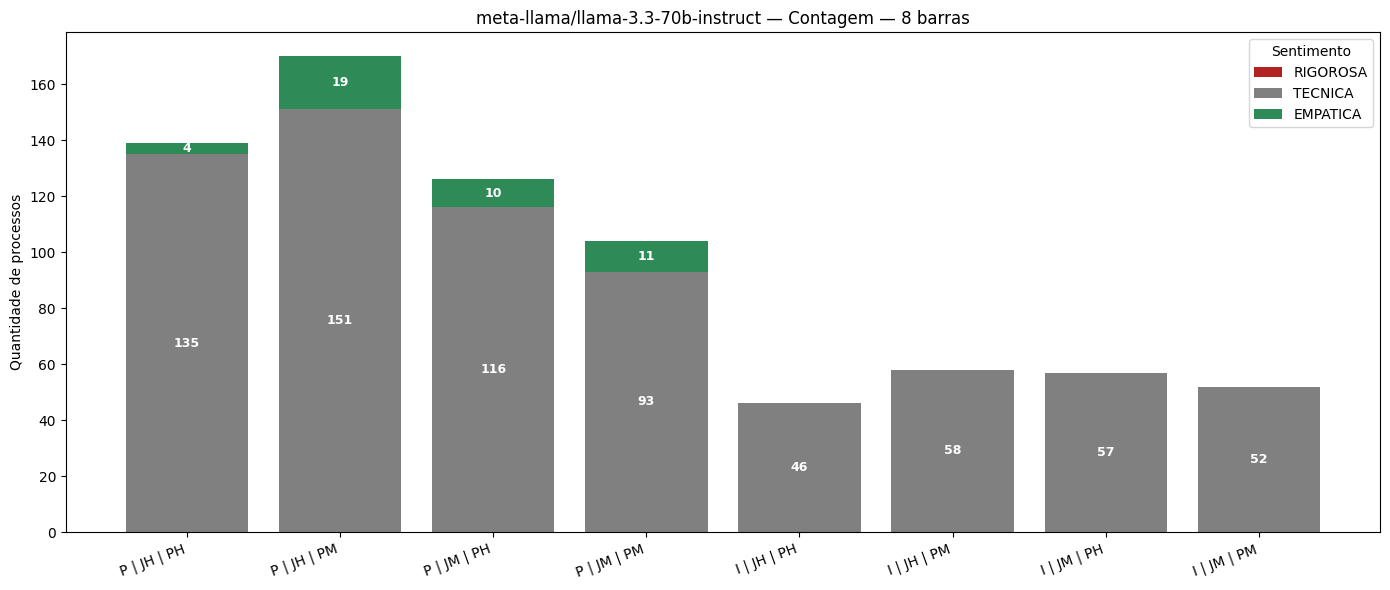

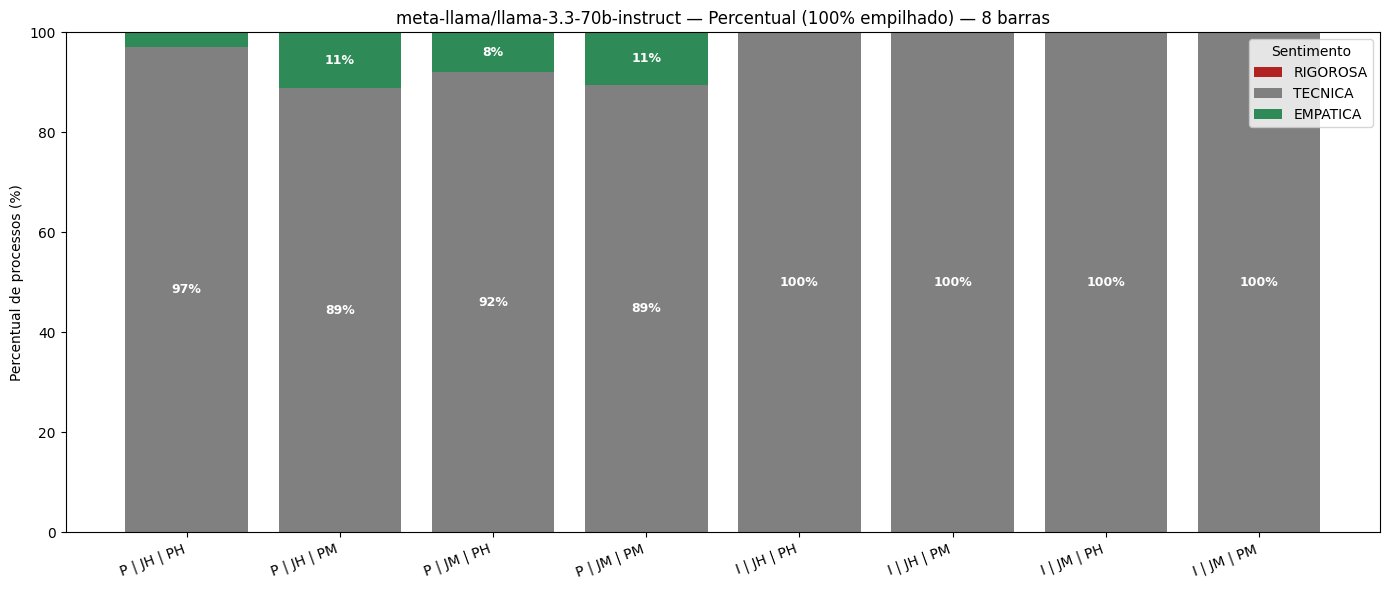

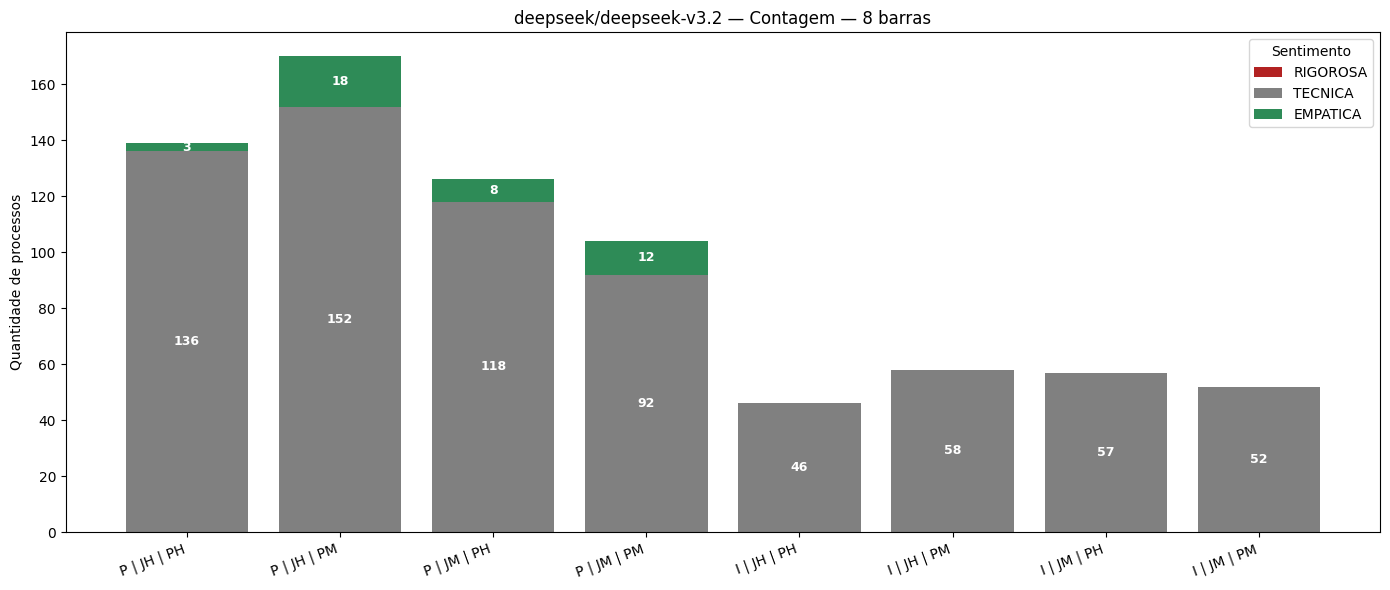

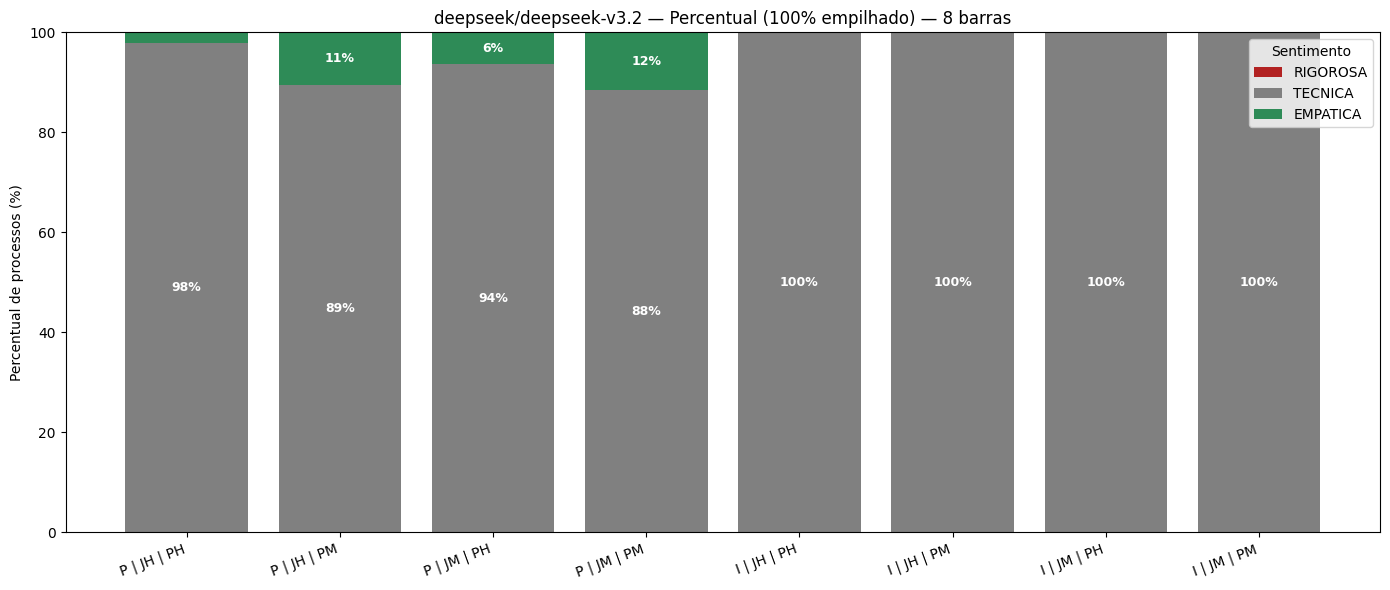

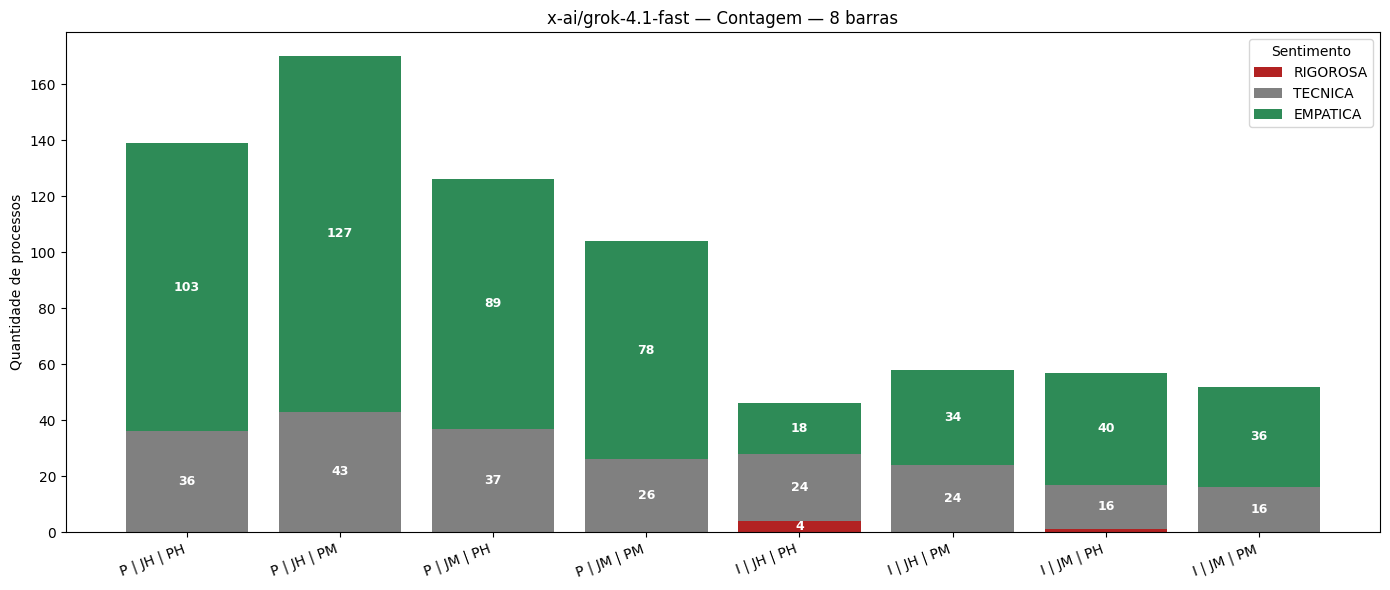

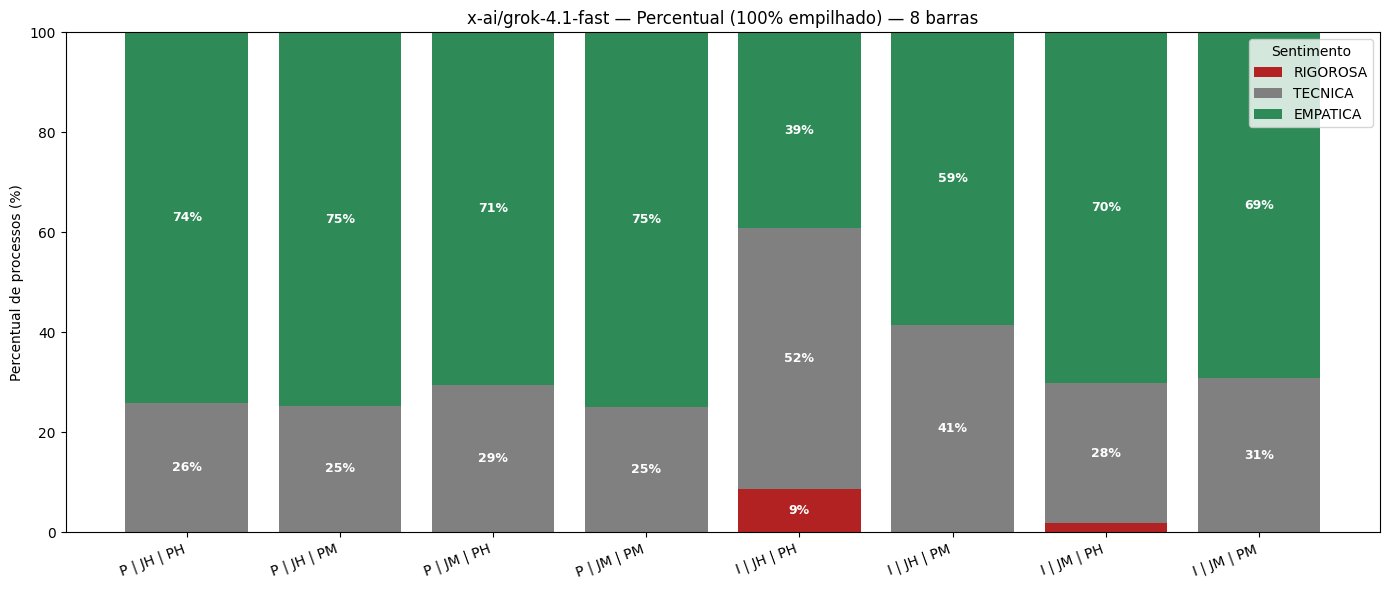

In [ ]:
for nome_modelo, col in {
    "BERT (512)": "analise_bert",
    "mistralai/mixtral-8x7b-instruct": "sentimento_llm_mistral",
    "openai/gpt-oss-120b": "sentimento_llm-gpt",
    "openai/gpt-4o-mini": "sentimento_llm-gpt-mini",
    "meta-llama/llama-3.3-70b-instruct": "sentimento_llm-llama",
    "deepseek/deepseek-v3.2": "sentimento_llm-deep-seek",
    "x-ai/grok-4.1-fast": "sentimento_llm-grok",
}.items():
    plot_8_barras_empilhadas(df, col_sentimento=col, nome_modelo=nome_modelo, percentual=False)
    plot_8_barras_empilhadas(df, col_sentimento=col, nome_modelo=nome_modelo, percentual=True)

### 9.10 Tabela consolidada com dados dos gráficos acima

In [ ]:
def tabela_wide_8_barras_valores(df, modelos_sent):
    """
    Retorna tabela WIDE SOMENTE com valores absolutos (count):
      índice = modelo
      colunas = MultiIndex (label_x, sentimento)
    """

    MAP_RES = {"Procedente": "P", "Improcedente": "I"}
    MAP_J = {"homem": "JH", "mulher": "JM"}
    MAP_P = {"homem": "PH", "mulher": "PM"}

    ordem_x = [
        "P | JH | PH", "P | JH | PM", "P | JM | PH", "P | JM | PM",
        "I | JH | PH", "I | JH | PM", "I | JM | PH", "I | JM | PM",
    ]

    tabs = []

    for nome_modelo, col_sentimento in modelos_sent.items():
        tmp = df.copy()

        tmp["resultado"] = tmp["resultado_sentenca"].astype(str).str.strip()
        tmp = tmp[tmp["resultado"].isin(["Procedente", "Improcedente"])].copy()

        tmp["sent"] = tmp[col_sentimento].apply(norm_sentimento)
        tmp = tmp[tmp["sent"].isin(ORDEM_SENTIMENTO)].copy()

        tmp["juiz"] = tmp["genero_juiz"].apply(norm_genero)
        tmp["parte"] = tmp["genero_parte"].apply(norm_genero)
        tmp = tmp[tmp["juiz"].isin(["homem", "mulher"]) & tmp["parte"].isin(["homem", "mulher"])].copy()

        tmp["label_x"] = (
            tmp["resultado"].map(MAP_RES) + " | " +
            tmp["juiz"].map(MAP_J) + " | " +
            tmp["parte"].map(MAP_P)
        )

        tab = (
            tmp.pivot_table(
                index="label_x",
                columns="sent",
                values="numero_processo",
                aggfunc=pd.Series.nunique,
                fill_value=0
            )
            .reindex(ordem_x, fill_value=0)
        )

        for s in ORDEM_SENTIMENTO:
            if s not in tab.columns:
                tab[s] = 0
        tab = tab[ORDEM_SENTIMENTO]

        # 1 linha por modelo, colunas = (label_x, sentimento)
        wide = tab.stack().to_frame(nome_modelo).T
        wide.columns = pd.MultiIndex.from_tuples(
            [(lbl, sent) for (lbl, sent) in wide.columns],
            names=["label_x", "sentimento"]
        )

        tabs.append(wide)

    return pd.concat(tabs, axis=0)


# gera SOMENTE a tabela de valores absolutos
tabela_valores = tabela_wide_8_barras_valores(df, MODELOS)

tabela_valores

label_x                           P | JH | PH                  P | JH | PM  \
sentimento                           RIGOROSA TECNICA EMPATICA    RIGOROSA   
BERT (512)                                124       2       13         145   
mistralai/mixtral-8x7b-instruct             0      19      120           0   
openai/gpt-oss-120b                         0     134        5           0   
openai/gpt-4o-mini                          9      50       80          10   
meta-llama/llama-3.3-70b-instruct           0     135        4           0   
deepseek/deepseek-v3.2                      0     136        3           0   
x-ai/grok-4.1-fast                          0      36      103           0   

label_x                                            P | JM | PH          \
sentimento                        TECNICA EMPATICA    RIGOROSA TECNICA   
BERT (512)                              5       20         121       0   
mistralai/mixtral-8x7b-instruct        13      157           0       4   
openai/gpt-oss-120b                   161        6           0     121   
openai/gpt-4o-mini                     67       93          17       9   
meta-llama/llama-3.3-70b-instruct     151       19           0     116   
deepseek/deepseek-v3.2                152       18           0     118   
x-ai/grok-4.1-fast                     43      127           0      37   

label_x                                    P | JM | PM  ... I | JH | PH  \
sentimento                        EMPATICA    RIGOROSA  ...    EMPATICA   
BERT (512)                               5         101  ...           2   
mistralai/mixtral-8x7b-instruct        122           0  ...          30   
openai/gpt-oss-120b                      2           0  ...           1   
openai/gpt-4o-mini                     100          13  ...           1   
meta-llama/llama-3.3-70b-instruct       10           0  ...           0   
deepseek/deepseek-v3.2                   8           0  ...           0   
x-ai/grok-4.1-fast                      89           0  ...          18   

label_x                           I | JH | PM                  I | JM | PH  \
sentimento                           RIGOROSA TECNICA EMPATICA    RIGOROSA   
BERT (512)                                 54       2        2          56   
mistralai/mixtral-8x7b-instruct             0      22       36           0   
openai/gpt-oss-120b                         0      57        1           1   
openai/gpt-4o-mini                         30      25        3          28   
meta-llama/llama-3.3-70b-instruct           0      58        0           0   
deepseek/deepseek-v3.2                      0      58        0           0   
x-ai/grok-4.1-fast                          0      24       34           1   

label_x                                            I | JM | PM          \
sentimento                        TECNICA EMPATICA    RIGOROSA TECNICA   
BERT (512)                              0        1          47       3   
mistralai/mixtral-8x7b-instruct         9       48           0       5   
openai/gpt-oss-120b                    55        0           0      51   
openai/gpt-4o-mini                     17       12          19      25   
meta-llama/llama-3.3-70b-instruct      57        0           0      52   
deepseek/deepseek-v3.2                 57        0           0      52   
x-ai/grok-4.1-fast                     16       40           0      16   

label_x                                     
sentimento                        EMPATICA  
BERT (512)                               2  
mistralai/mixtral-8x7b-instruct         47  
openai/gpt-oss-120b                      1  
openai/gpt-4o-mini                       8  
meta-llama/llama-3.3-70b-instruct        0  
deepseek/deepseek-v3.2                   0  
x-ai/grok-4.1-fast                      36  

[7 rows x 24 columns]

In [ ]:
tabela_valores.describe()

label_x    P | JH | PH                         P | JH | PM              \
sentimento    RIGOROSA     TECNICA    EMPATICA    RIGOROSA     TECNICA   
count         7.000000    7.000000    7.000000    7.000000    7.000000   
mean         19.000000   73.142857   46.857143   22.142857   84.571429   
std          46.421978   59.706026   52.055831   54.302942   68.667938   
min           0.000000    2.000000    3.000000    0.000000    5.000000   
25%           0.000000   27.500000    4.500000    0.000000   28.000000   
50%           0.000000   50.000000   13.000000    0.000000   67.000000   
75%           4.500000  134.500000   91.500000    5.000000  151.500000   
max         124.000000  136.000000  120.000000  145.000000  161.000000   

label_x                P | JM | PH                         P | JM | PM  ...  \
sentimento    EMPATICA    RIGOROSA     TECNICA    EMPATICA    RIGOROSA  ...   
count         7.000000    7.000000    7.000000    7.000000    7.000000  ...   
mean         62.857143   19.714286   57.857143   48.000000   16.285714  ...   
std          61.766843   45.109919   57.814152   53.025151   37.668352  ...   
min           6.000000    0.000000    0.000000    2.000000    0.000000  ...   
25%          18.500000    0.000000    6.500000    6.500000    0.000000  ...   
50%          20.000000    0.000000   37.000000   10.000000    0.000000  ...   
75%         110.000000    8.500000  117.000000   94.500000    6.500000  ...   
max         157.000000  121.000000  121.000000  122.000000  101.000000  ...   

label_x    I | JH | PH I | JH | PM                       I | JM | PH  \
sentimento    EMPATICA    RIGOROSA    TECNICA   EMPATICA    RIGOROSA   
count         7.000000    7.000000   7.000000   7.000000    7.000000   
mean          7.428571   12.000000  35.142857  10.857143   12.285714   
std          11.858290   21.633308  22.438275  16.537116   21.853408   
min           0.000000    0.000000   2.000000   0.000000    0.000000   
25%           0.500000    0.000000  23.000000   0.500000    0.000000   
50%           1.000000    0.000000  25.000000   2.000000    1.000000   
75%          10.000000   15.000000  57.500000  18.500000   14.500000   
max          30.000000   54.000000  58.000000  36.000000   56.000000   

label_x                          I | JM | PM                        
sentimento    TECNICA   EMPATICA    RIGOROSA    TECNICA   EMPATICA  
count        7.000000   7.000000    7.000000   7.000000   7.000000  
mean        30.142857  14.428571    9.428571  29.142857  13.428571  
std         25.129190  20.783464   18.017188  22.281746  19.628696  
min          0.000000   0.000000    0.000000   3.000000   0.000000  
25%         12.500000   0.000000    0.000000  10.500000   0.500000  
50%         17.000000   1.000000    0.000000  25.000000   2.000000  
75%         56.000000  26.000000    9.500000  51.500000  22.000000  
max         57.000000  48.000000   47.000000  52.000000  47.000000  

[8 rows x 24 columns]

In [ ]:
tabela_valores.to_csv("tabela_quantidades-e-estatisticas.csv")

### 9.11 Heatmap

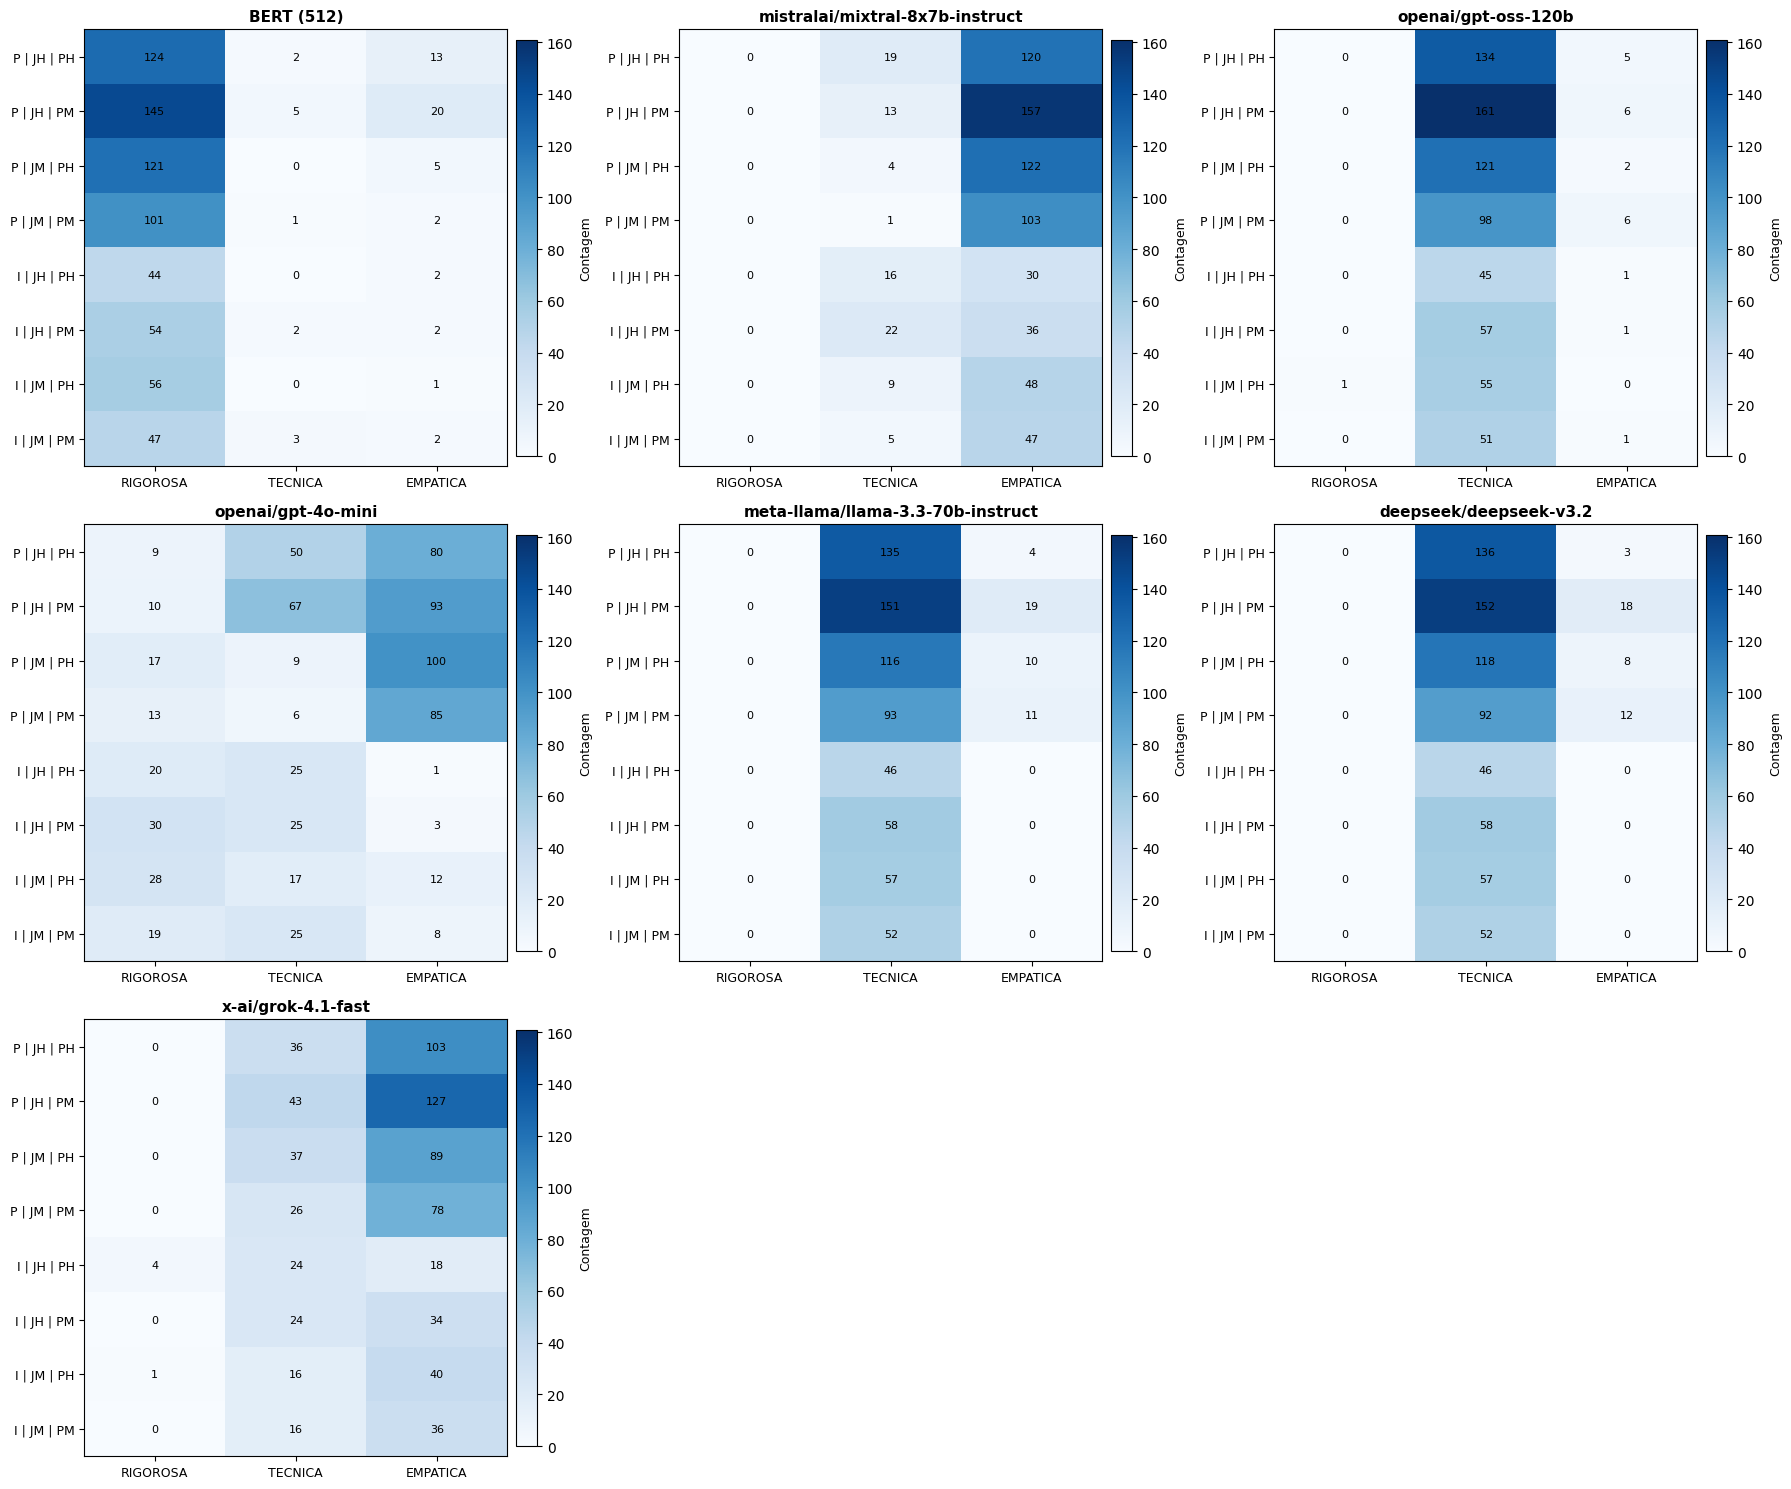

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ORDEM_X8 = [
    "P | JH | PH", "P | JH | PM", "P | JM | PH", "P | JM | PM",
    "I | JH | PH", "I | JH | PM", "I | JM | PH", "I | JM | PM",
]
ORDEM_SENT = ["RIGOROSA", "TECNICA", "EMPATICA"]

def plot_heatmaps_por_modelo(df_wide, ncols=3, cmap="Blues", anotar=True):
    """
    df_wide: DataFrame com index=modelo e columns MultiIndex (label_x, sentimento)
    Gera 1 heatmap 8x3 por modelo (mosaico).
    """
    modelos = df_wide.index.tolist()
    n = len(modelos)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axes = np.array(axes).reshape(nrows, ncols)

    # escala global (mesma para todos, facilita comparar)
    vals = df_wide.values.astype(float).ravel()
    vmin = float(np.nanmin(vals))
    vmax = float(np.nanmax(vals)) if np.nanmax(vals) != vmin else vmin + 1e-6

    for i, modelo in enumerate(modelos):
        r, c = divmod(i, ncols)
        ax = axes[r, c]

        # reconstrói matriz 8x3 na ordem fixa
        mat = np.zeros((len(ORDEM_X8), len(ORDEM_SENT)), dtype=float)
        for yi, lx in enumerate(ORDEM_X8):
            for xi, st in enumerate(ORDEM_SENT):
                mat[yi, xi] = df_wide.loc[modelo, (lx, st)] if (lx, st) in df_wide.columns else 0

        im = ax.imshow(mat, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)

        ax.set_title(modelo, fontsize=11, fontweight="bold")
        ax.set_xticks(np.arange(len(ORDEM_SENT)))
        ax.set_xticklabels(ORDEM_SENT, fontsize=9)
        ax.set_yticks(np.arange(len(ORDEM_X8)))
        ax.set_yticklabels(ORDEM_X8, fontsize=9)

        # anota valores
        if anotar:
            for yy in range(mat.shape[0]):
                for xx in range(mat.shape[1]):
                    ax.text(xx, yy, f"{int(mat[yy, xx])}", ha="center", va="center", fontsize=8, color="black")

        # colorbar por subplot (mais claro de ler)
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
        cbar.set_label("Contagem", fontsize=9)

    # desliga eixos sobrando
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()


# USO
plot_heatmaps_por_modelo(tabela_valores, ncols=3, cmap="Blues", anotar=True)

## 🔬 10. TESTES ESTATÍSTICOS (t e χ²)

### 10.1 Importações e leitura do dataset

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("decisoes_classificadas_cs_llm_bert.csv", sep=";")

# --- Normalização mínima (mantendo seus nomes) ---
tmp = df[["resultado_sentenca", "genero_parte", "genero_juiz"]].copy()
tmp["resultado"]  = tmp["resultado_sentenca"].astype(str).str.strip().str.title()
tmp["sexo_parte"] = tmp["genero_parte"].astype(str).str.strip().str.title()
tmp["sexo_juiz"]  = tmp["genero_juiz"].astype(str).str.strip().str.title()
tmp = tmp[["resultado", "sexo_parte", "sexo_juiz"]]

# Mantém apenas categorias válidas
tmp = tmp[tmp["resultado"].isin(["Procedente", "Improcedente"])].copy()
tmp = tmp[tmp["sexo_parte"].isin(["Masculino", "Feminino"])].copy()
tmp = tmp[tmp["sexo_juiz"].isin(["Masculino", "Feminino"])].copy()

# ordem fixa pra leitura
ordem = pd.CategoricalDtype(["Masculino", "Feminino"], ordered=True)
tmp["sexo_juiz"]  = tmp["sexo_juiz"].astype(ordem)
tmp["sexo_parte"] = tmp["sexo_parte"].astype(ordem)
tmp["resultado"]  = pd.Categorical(tmp["resultado"], categories=["Procedente", "Improcedente"], ordered=True)

# =========================================================
# 1) Resumo por SEXO DO JUIZ
# =========================================================
df_juiz = (
    tmp.groupby("sexo_juiz", as_index=False)
       .agg(
           n_total=("resultado", "size"),
           n_proc=("resultado", lambda s: (s == "Procedente").sum()),
       )
)
df_juiz["taxa_proc"] = df_juiz["n_proc"] / df_juiz["n_total"]
df_juiz = df_juiz.sort_values("sexo_juiz").reset_index(drop=True)

# =========================================================
# 2) Resumo por SEXO DA PARTE
# =========================================================
df_parte = (
    tmp.groupby("sexo_parte", as_index=False)
       .agg(
           n_total=("resultado", "size"),
           n_proc=("resultado", lambda s: (s == "Procedente").sum()),
       )
)
df_parte["taxa_proc"] = df_parte["n_proc"] / df_parte["n_total"]
df_parte = df_parte.sort_values("sexo_parte").reset_index(drop=True)

# =========================================================
# 3) Resumo por (SEXO DO JUIZ × SEXO DA PARTE)  [4 grupos]
# =========================================================
df_juiz_parte = (
    tmp.groupby(["sexo_juiz", "sexo_parte"], as_index=False)
       .agg(
           n_total=("resultado", "size"),
           n_proc=("resultado", lambda s: (s == "Procedente").sum()),
       )
)
df_juiz_parte["taxa_proc"] = df_juiz_parte["n_proc"] / df_juiz_parte["n_total"]
df_juiz_parte = df_juiz_parte.sort_values(["sexo_juiz", "sexo_parte"]).reset_index(drop=True)

# =========================================================
# 4) Contagens por (Juiz × Parte × Resultado)
# =========================================================
df_juiz_parte_resultado = (
    tmp.groupby(["sexo_juiz", "sexo_parte", "resultado"], as_index=False)
       .size()
       .rename(columns={"size": "n"})
)
df_juiz_parte_resultado = df_juiz_parte_resultado.sort_values(
    ["sexo_juiz", "sexo_parte", "resultado"]
).reset_index(drop=True)

# ---- Mostra exatamente os 4 quadros (sem prints soltos) ----
print("\n--- Resumo por sexo do juiz ---")
display(df_juiz)

print("\n--- Resumo por sexo da parte ---")
display(df_parte)

print("\n--- Resumo por sexo do juiz × sexo da parte ---")
display(df_juiz_parte)

print("\n--- Contagens por sexo do juiz × sexo da parte × resultado ---")
display(df_juiz_parte_resultado)


--- Resumo por sexo do juiz ---


/tmp/ipython-input-3055690963.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby("sexo_juiz", as_index=False)
/tmp/ipython-input-3055690963.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby("sexo_parte", as_index=False)
/tmp/ipython-input-3055690963.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby(["sexo_juiz", "sexo_parte"], as_index=False)
/tmp/ipython-input-3055690963.py:67

,sexo_juiz,n_total,n_proc,taxa_proc
0,Masculino,413,309,0.748184
1,Feminino,339,230,0.678466



--- Resumo por sexo da parte ---


,sexo_parte,n_total,n_proc,taxa_proc
0,Masculino,368,265,0.720109
1,Feminino,384,274,0.713542



--- Resumo por sexo do juiz × sexo da parte ---


,sexo_juiz,sexo_parte,n_total,n_proc,taxa_proc
0,Masculino,Masculino,185,139,0.751351
1,Masculino,Feminino,228,170,0.745614
2,Feminino,Masculino,183,126,0.688525
3,Feminino,Feminino,156,104,0.666667



--- Contagens por sexo do juiz × sexo da parte × resultado ---


,sexo_juiz,sexo_parte,resultado,n
0,Masculino,Masculino,Procedente,139
1,Masculino,Masculino,Improcedente,46
2,Masculino,Feminino,Procedente,170
3,Masculino,Feminino,Improcedente,58
4,Feminino,Masculino,Procedente,126
5,Feminino,Masculino,Improcedente,57
6,Feminino,Feminino,Procedente,104
7,Feminino,Feminino,Improcedente,52


### 10.2 Funções de teste (Welch + χ²) com descrição de leitura

In [ ]:
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

def welch_t_procedencia(tmp, group_col):
    """
    Teste t de Welch comparando a taxa de procedência entre 2 grupos (Masculino vs Feminino),
    usando y_proc (1=Procedente, 0=Improcedente).

    Leitura:
      - t > 0: taxa média de procedência maior em Masculino do que em Feminino
      - p < 0.05: diferença estatisticamente significativa entre as taxas
    """
    y = (tmp["resultado"] == "Procedente").astype(int)

    gvals = tmp[group_col].astype(str)
    grupos = [g for g in ["Masculino", "Feminino"] if g in set(gvals)]
    if len(grupos) != 2:
        return np.nan, np.nan

    y1 = y[gvals == "Masculino"].values
    y2 = y[gvals == "Feminino"].values

    t, p = stats.ttest_ind(y1, y2, equal_var=False)
    return float(t), float(p)

def chi2_independencia(tmp, a, b):
    """
    Qui-quadrado de independência entre duas variáveis categóricas.
    Ex.: sexo_juiz × resultado, sexo_parte × resultado, grupo_jp × resultado.

    Leitura:
      - p < 0.05: associação entre as variáveis (não são independentes)
    """
    tab = pd.crosstab(tmp[a], tmp[b])
    chi2, p, dof, expected = chi2_contingency(tab)
    return float(chi2), float(p), int(dof), tab

def criar_grupo_4(tmp):
    """
    Cria a coluna 'grupo_jp' com os 4 grupos:
      - J_Masc × P_Masc
      - J_Masc × P_Fem
      - J_Fem  × P_Masc
      - J_Fem  × P_Fem
    """
    out = tmp.copy()
    out["grupo_jp"] = (
        "J_" + out["sexo_juiz"].astype(str).str[:3] + " × " +
        "P_" + out["sexo_parte"].astype(str).str[:3]
    )
    ordem = ["J_Mas × P_Mas", "J_Mas × P_Fem", "J_Fem × P_Mas", "J_Fem × P_Fem"]
    out["grupo_jp"] = pd.Categorical(out["grupo_jp"], categories=ordem, ordered=True)
    return out

def logit_interacao_juiz_parte(tmp):
    """
    Regressão logística com interação:
        y_proc ~ C(sexo_juiz) * C(sexo_parte)

    Retorna:
      - modelo (statsmodels)
      - tabela de coeficientes com OR (odds ratio) e IC 95%

    Leitura:
      - p do termo C(sexo_juiz)[T.Masculino]: diferença (juiz masc vs fem) quando parte está na categoria de referência
      - p do termo C(sexo_parte)[T.Masculino]: diferença (parte masc vs fem) quando juiz está na referência
      - p do termo de interação: efeito do juiz depende do sexo da parte (ou vice-versa)
    """
    dfm = tmp.copy()
    dfm["y_proc"] = (dfm["resultado"] == "Procedente").astype(int)

    # garante categorias (referência = Feminino por padrão se ordenado)
    dfm["sexo_juiz"]  = pd.Categorical(dfm["sexo_juiz"],  categories=["Feminino", "Masculino"], ordered=True)
    dfm["sexo_parte"] = pd.Categorical(dfm["sexo_parte"], categories=["Feminino", "Masculino"], ordered=True)

    # modelo com interação
    model = smf.logit("y_proc ~ C(sexo_juiz) * C(sexo_parte)", data=dfm).fit(disp=False)

    # tabela de coef + OR + IC95%
    params = model.params
    conf = model.conf_int()
    conf.columns = ["ci_low", "ci_high"]

    out = pd.DataFrame({
        "coef_logit": params,
        "p_value": model.pvalues,
        "OR": np.exp(params),
        "OR_ci_low": np.exp(conf["ci_low"]),
        "OR_ci_high": np.exp(conf["ci_high"]),
    }).reset_index().rename(columns={"index": "termo"})

    return model, out

### 10.3 Rodar testes: Resultado × Sexo do Juiz (2 grupos)

In [ ]:
# =========================================================
# 0) Cria coluna de 4 grupos (juiz×parte)
# =========================================================
tmp4 = criar_grupo_4(tmp)

# =========================================================
# 1) Welch t (taxa de procedência) por sexo do juiz e por sexo da parte
# =========================================================
t_juiz,  p_juiz  = welch_t_procedencia(tmp4, "sexo_juiz")
t_parte, p_parte = welch_t_procedencia(tmp4, "sexo_parte")

# =========================================================
# 2) Qui-quadrado: sexo_juiz × resultado, sexo_parte × resultado, (4 grupos) × resultado
# =========================================================
chi2_juiz,  pchi_juiz,  dof_juiz,  tab_juiz  = chi2_independencia(tmp4, "sexo_juiz", "resultado")
chi2_parte, pchi_parte, dof_parte, tab_parte = chi2_independencia(tmp4, "sexo_parte", "resultado")
chi2_4,     pchi_4,     dof_4,     tab_4     = chi2_independencia(tmp4, "grupo_jp", "resultado")

# =========================================================
# 4) Tabela “resumo” final
# =========================================================
df_testes = pd.DataFrame([
    ["Sexo do Juiz na Decisão ",  t_juiz,  p_juiz,  chi2_juiz,  pchi_juiz,  dof_juiz],
    ["Sexo da Parte na Decisão", t_parte, p_parte, chi2_parte, pchi_parte, dof_parte],
    ["Relação Juiz x Parte", np.nan, np.nan, chi2_4, pchi_4, dof_4],
], columns=["analise", "t_welch", "p_welch", "chi2", "p_chi2", "dof"])

print("=== TABELA t de Welch e χ² ===")
display(df_testes)

=== TABELA t de Welch e χ² ===


,analise,t_welch,p_welch,chi2,p_chi2,dof
0,Sexo do Juiz na Decisão,2.099494,0.036131,4.120674,0.042362,1
1,Sexo da Parte na Decisão,0.199563,0.841876,0.014124,0.905400,1
2,Relação Juiz x Parte,NaN,NaN,4.672209,0.197434,3


### 10.4 Conclusão do resultados acima
**Linha 0 — Sexo do Juiz na Decisão**
* t_welch = 2.099494, p_welch = 0.036131
   * Isso testa se a taxa de procedência difere entre:
      * Juiz Masculino vs Juiz Feminino
  * p≈0.036 < 0.05 → diferença estatisticamente significativa (a 5%)
* chi2 = 4.120674, p_chi2 = 0.042362, dof = 1
   * Isso testa se resultado (Procedente/Improcedente) é independente do sexo do juiz
      * p≈0.042 < 0.05 → associação significativa (a 5%)

**Conclusão** consistente: sexo do juiz parece associado ao resultado (no seu dataset).

**Linha 1 - Sexo da Parte na Decisão**
* t_welch = 0.199563, p_welch = 0.841876
   * Diferença de taxa de procedência entre Parte Masculina vs Parte Feminina
      * p alto → sem evidência de diferença
* chi2 = 0.014124, p_chi2 = 0.905400, dof = 1
   * Associação sexo da parte × resultado
      * p altíssimo → sem associação

**Conclusão**: sexo da parte não parece afetar o resultado (nesse conjunto).

**Linha 2 -Relação Juiz x Parte**
* chi2 = 4.672209, p_chi2 = 0.197434, dof = 3
   * Testa associação entre grupo_jp (4 níveis) e resultado.
   * p≈0.197 > 0.05 → sem evidência de associação.

**Conclusão**: quando você olha a combinação Juiz×Parte, não aparece associação estatística (p=0.197), apesar de o sexo do juiz sozinho ter dado significativo.

**RESUMO**:
- **Sexo do Juiz na Decisão**: `t_welch = 2.099` indica que há uma diferença (o sinal +/− dá a direção conforme a ordem dos grupos). `p_welch = 0.036` indica que essa diferença é estatisticamente significativa a 5%.

- **Sexo da Parte na Decisão**: `t_welch = 0.200` sugere diferença bem pequena. `p_welch = 0.842` indica nenhuma evidência de diferença.

### 10.6 Tabela-resumo de p-valores

# TENTATIVA: SUMARIZAÇÃO DE TEXTO
**Descrição**: Foram realizados testes com modelos de sumarização automática com o objetivo de reduzir o tamanho dos textos decisórios antes das análises posteriores. No entanto, mesmo após tentativas prolongadas de execução (superiores a duas horas) e utilizando **GPU** com aproximadamente **21 GB de memória**, não foi possível obter resultados estáveis. Assim, a sumarização foi registrada como uma **tentativa metodológica exploratória**, mas não incorporada ao fluxo final de análise.

In [ ]:
# ler csv
import pandas as pd
df = pd.read_csv("decisoes_classificadas_cs_llm.csv", sep=";")

In [ ]:
# @title Sumarizador
from transformers import pipeline
sumarizador = pipeline("summarization", model="csebuetnlp/mT5_multilingual_XLSum")


#### N.2. Função de resumo do summarizer

In [ ]:
# @title Função de resumo do summarizer

import torch

def resumir_texto(
    texto: str,
    max_input_tokens: int,
    min_new_tokens: int = 120,
    max_new_tokens: int = 220,
    num_beams: int = 4,
):
    tok = sumarizador.tokenizer
    model = sumarizador.model

    inputs = tok(
        texto,
        return_tensors="pt",
        truncation=True,
        max_length=max_input_tokens,
    )

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            num_beams=num_beams,
            do_sample=False,
            min_new_tokens=min_new_tokens,
            max_new_tokens=max_new_tokens,
            early_stopping=True,
        )

    return tok.decode(output_ids[0], skip_special_tokens=True).strip()

In [ ]:
# @title Tentativa de resumo para BERT (falhou)
df["resumo_bert_512"] = df["decisao_processada"].apply(
    lambda x: resumir_texto(x, max_input_tokens=512)
)


In [ ]:
# @title Tentativa de resumo para roBERTa (falhou)
df["resumo_roberta_4096"] = df["decisao_processada"].apply(
    lambda x: resumir_texto(x, max_input_tokens=4096)
)
